###### Assignment 2: Manual Motion Observation - Conducted Experiment

#### Team members: Ujjwal Patil, Amol Tatkari, Behrouz Ghamkhar

#### Program and parameters to drive the robot
- The robot is positioned so that its rear-end markers align with the X-axis and the front-end marker aligns with the Y-axis of the chart.
- Added a short delay between pressing the button and start of robot movement to lift off finger from button, which avoids misalignment at start due to human interference.
- The csv file for readings is updated instead of being overwritten.

In [32]:
#!/usr/bin/env micropython

if False:

    from time import sleep
    import sys
    import math 
    from ev3dev2.motor import LargeMotor, OUTPUT_A, OUTPUT_B, OUTPUT_C, OUTPUT_D, SpeedPercent, MoveTank
    from ev3dev2.sensor import INPUT_1, INPUT_2, INPUT_3, INPUT_4
    from ev3dev2.sound import Sound
    from ev3dev2.button import Button

    WHEEL_DIAMETER = 5.6 # cm
    MAIN_AXIS_LENGTH = 12 # cm

    buttons = Button()
    move = MoveTank(OUTPUT_A, OUTPUT_D)
    spkr = Sound()
    motor_1 = LargeMotor(OUTPUT_A)
    motor_2 = LargeMotor(OUTPUT_D)

    motor_1_path = [] # in rad
    motor_2_path = [] # in rad

    motor_1_path.append(motor_1.position)
    motor_2_path.append(motor_2.position)

    robot_orientation = 0.0 # in rad
    robot_position_x  = 0.0 # in cm
    robot_position_y  = 0.0 # in cm

    distance_traveled_wheel_1 = 0.0 # in cm
    distance_traveled_wheel_2 = 0.0 # in cm

    last_pose = ()

    def add_data_to_csv(x, y, orientation, file_name):

        with open(file_name,'a') as robot_poses:
            #writer = csv.writer(robot_poses)
            #writer.writerows([x, y, orientation])
            robot_poses.write(str(str(x) + " " + str(y)+ " " + str(orientation) + "\n"))

    spkr.speak('Press a button')
    while True:
        if buttons.left:
            sleep(0.7)
            move.on_for_seconds(SpeedPercent(-30), SpeedPercent(-40), 2.2, block=False)

        elif buttons.down:
            sleep(0.7)
            move.on_for_seconds(SpeedPercent(-40), SpeedPercent(-40), 2.2, block=False)

        elif buttons.right:
            sleep(0.7)
            move.on_for_seconds(SpeedPercent(-40), SpeedPercent(-30), 2.2, block=False)

        if (motor_1.is_running): motor_1_path.append((motor_1.position * math.pi) / 180.0)
        if (motor_2.is_running): motor_2_path.append((motor_2.position * math.pi) / 180.0)

        if (motor_1.is_holding and motor_2.is_holding):
            data_length = min(len(motor_1_path), len(motor_2_path))

            with open('both_motors_path.csv', "w") as f_wheels_path:
                for i in range(data_length):
                    f_wheels_path.write(str(str(motor_1_path[i]) + " " + str(motor_2_path[i]) + "\n")) # in rad

            #with open('robot_path.csv', "w") as f_robot_path:
            for i in range(data_length):
                if i == 0:
                    distance_traveled_wheel_1 = (WHEEL_DIAMETER * math.pi * motor_1_path[0]) / (2 * math.pi)
                    distance_traveled_wheel_2 = (WHEEL_DIAMETER * math.pi * motor_2_path[0]) / (2 * math.pi)
                else:
                    distance_traveled_wheel_1 = (WHEEL_DIAMETER * math.pi * (motor_1_path[i] - motor_1_path[i - 1])) / (2 * math.pi)
                    distance_traveled_wheel_2 = (WHEEL_DIAMETER * math.pi * (motor_2_path[i] - motor_2_path[i - 1])) / (2 * math.pi)

                delta_distance = (distance_traveled_wheel_1 + distance_traveled_wheel_2) / 2
                delta_angle    = (distance_traveled_wheel_1 - distance_traveled_wheel_2) / MAIN_AXIS_LENGTH

                robot_orientation = robot_orientation + delta_angle
                robot_position_x  = robot_position_x  + delta_distance * math.sin(robot_orientation)
                robot_position_y  = robot_position_y  + delta_distance * math.cos(robot_orientation)
                last_pose = (robot_position_x, robot_position_y, robot_orientation)

                #f_robot_path.write(str(robot_position_x) + " " + str(robot_position_y) + " " + str((math.pi / 2) - robot_orientation) + "\n") # in cm and rad
                add_data_to_csv(robot_position_x, robot_position_y, (math.pi / 2) - robot_orientation, 'robot_path.csv')
            spkr.speak('Motion completed')
            add_data_to_csv(0,0, 0, 'robot_path.csv')
            add_data_to_csv(last_pose[0], last_pose[1], last_pose[2], 'robot_poses.csv')
            break

        # don't let this loop use 100% CPU
        sleep(0.001)

In [33]:
if False:
    spkr.speak('Press a button')
    while True:
        if buttons.left:
            sleep(0.7)   #Added delay to lift off finger from button
            move.on_for_seconds(SpeedPercent(-30), SpeedPercent(-40), 2.2, block=False)

        elif buttons.down:
            sleep(0.7)
            move.on_for_seconds(SpeedPercent(-40), SpeedPercent(-40), 2.2, block=False)

        elif buttons.right:
            sleep(0.7)
            move.on_for_seconds(SpeedPercent(-40), SpeedPercent(-30), 2.2, block=False)

#### Observations Made During Execution
The following observations were made during the experiment:
- When the robot starts and stops, it experiences a jerk that causes a slight deviation from its path.
- After a certain amount of markings, it becomes difficult to identify and take measurements of the point marked.
- The tip of the pen might not make the point dark enough when highlighting.

#### Measured Data
The readings for all three motions that the robot performed, which are straight, left, and right, are provided in the subsequent tables.

In [34]:
import numpy as np
import pandas as pd
from scipy.stats import norm 

# Set precision
np.set_printoptions(precision=1, suppress=True)
pd.set_option('display.float_format', '{:0.1f}'.format)

file = open("manual_data_with_centroid.txt", "r")

content =file.readlines()
data=''.join(content[0:75])
reshaped_data = np.array([float(num) for num in data.split()]).reshape(75,8)
reshaped_data = np.round(reshaped_data, decimals=2)

centroid_orientation=[]
for data in reshaped_data:
    orientation=np.arctan2((data[1]-0.5*(data[3]+data[5])),(data[0]-0.5*(data[2]+data[4])))
    #orientation = np.arctan2((data[3]+data[5] - 2 * data[1]) / 2, (data[2]+data[4] - 2* data[0]) / 2) 
    centroid_orientation.append(orientation)

centroid_orientation = np.array(centroid_orientation).reshape(75, 1)
reshaped_data = np.hstack((reshaped_data, centroid_orientation))

column_names = columns = pd.MultiIndex.from_tuples([
    ('Front' , 'x (cm) <br> ± 0.5 '), ('Front', 'y (cm) <br> ± 0.5'),
    ('Rear Left', 'x (cm) <br> ± 0.5'), ('Rear Left', 'y (cm) <br> ± 0.5'),
    ('Rear Right', 'x (cm) <br> ± 0.5'), ('Rear Right', 'y (cm) <br> ± 0.5'),
    ('Centroid', 'x (cm) <br> ± 0.5'), ('Centroid', 'y (cm) <br> ± 0.5'), ('Centroid', 'orientation (rad) <br> ± 0.02')])

# Convert to a pandas DataFrame
df = pd.DataFrame(reshaped_data[0:25], columns = column_names)

def style_frame(df, description: str, manual_data = False):
    styled_df = df.style.set_table_styles(
    [{
        'selector': 'th, td',  # Select both table headers and cells
        'props': [('border', '2px solid black'),  ('text-align', 'center'), ('width', '2%')]  # Set a 2px solid black border
    },
        {
            'selector': 'caption',  
            'props': [
                ('caption-side', 'top'),
                ('text-align', 'center'),  
                ('font-weight', 'bold'),   
                ('font-size', '16px'),
                ('color', 'black')
            ]
        }]
    ).format(precision=1).set_properties(**{
    'width': '100%',
    'border-color': 'black',  # Border color for all table elements
    'border-width': '2px',
    'border-style': 'solid'
    }).set_caption(description)
    
    if manual_data:
        styled_df.format(
        {('Centroid', 'orientation (rad) <br> ± 0.02'): "{:.2f}",  # Set 3 decimal places for orientation column
         **{col: "{:.1f}" for col in df.columns if col != ('Centroid', 'orientation (rad) <br> ± 0.02')}}  # 1 decimal place for others
    )
    return styled_df

In [35]:
display(style_frame(df, "Table 1: Manual Measurement Straight", True))

In [36]:
df = pd.DataFrame(reshaped_data[25:50], columns = column_names)
display(style_frame(df, "Table 2: Manual Measurement Left", True))

In [37]:
df = pd.DataFrame(reshaped_data[50:75], columns = column_names)
display(style_frame(df, "Table 3: Manual Measurement Right", True))

#### Visualization of the observed data
- All the readings, when visualized, will form a cluster. This cluster will help us estimate the approximate end pose for the motion being experimented.

1. Robot’s encoder path for all trials
2. Complete robot’s measured data and encoder data
3. Combined data of all teams

In [38]:
import numpy as np
import matplotlib.pyplot as plt


def plot_encoder_data():
    file = open("robot_path.csv", "r")
    content =file.readlines()
    data=''.join(content)
    path_list = np.array([float(num) for num in data.split()]).reshape(-1,3)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    # 5587 straight
    # 11146 left
    # the rest is right

    direction_fix = -1
    translation_fix = 6.76

    plt.scatter(path_list[:5587:5,0] * direction_fix , path_list[:5587:5,1] * direction_fix + translation_fix, s=0.2, c='#00ff00',marker="o",edgecolors='blue',  label = "Encoder Straight")
    plt.scatter(path_list[5587:11146:5,0] * direction_fix , path_list[5587:11146:5,1] * direction_fix + translation_fix, s=0.2,c='#00ff00',marker="o",edgecolors='orange',  label = "Encoder Left")
    plt.scatter(path_list[11146::5,0] * direction_fix , path_list[11146::5,1] * direction_fix + translation_fix, s=0.2,c='#00ff00',marker="o",edgecolors='green',  label = "Encoder Right")
    plt.scatter([0],[0],s=80,c='#ff0000',marker="X",edgecolors='black', linewidth=0.2, label = 'Start Point')


    #plt.axis((-100, 100, 100, 100))
    plt.ylim(-5, 75)
    plt.xlim(-40, 40)
    circle1 = plt.Circle((-25, 55), 5, color='b', fill=False,  label = "Scale Check")

    plt.gca().add_patch(circle1)
    plt.legend()
    plt.grid()
    plt.gcf().text(0.5, 0.9, "Robot’s encoder path for all trials", ha='center')
    plt.xlabel("X(cm)")
    plt.ylabel("Y(cm)")
    plt.show()

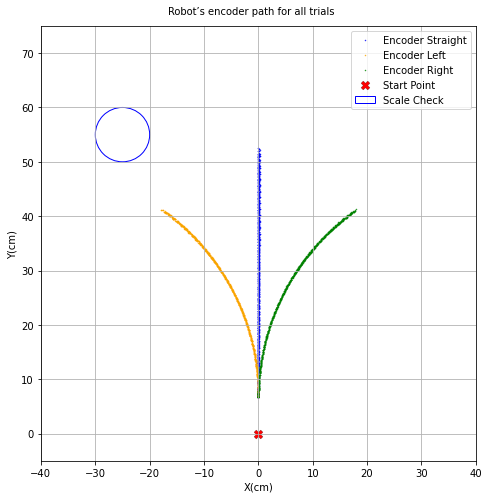

In [39]:
plot_encoder_data()

In [40]:
import numpy as np
import matplotlib.pyplot as plt


def plot_compelete_data():
    file = open("manual_data_with_centroid.txt", "r")
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    content =file.readlines()
    data=''.join(content[0:75])
    reshaped_data = np.array([float(num) for num in data.split()]).reshape(300,2)
    reshaped_data = np.round(reshaped_data, decimals=2)

    reshaped_data_for_mean_calc=reshaped_data.reshape(75,8)

    centroid_orientation=[]
    for data in reshaped_data_for_mean_calc:
        orientation=np.arctan2((data[1]-0.5*(data[3]+data[5])),(data[0]-0.5*(data[2]+data[4])))
        #orientation = np.arctan2((data[3]+data[5] - 2 * data[1]) / 2, (data[2]+data[4] - 2* data[0]) / 2) 
        centroid_orientation.append(orientation)
        
        
    line_length = 2.0 
    for i in range(len(centroid_orientation)):
        x_start = reshaped_data_for_mean_calc[i][6]
        y_start = reshaped_data_for_mean_calc[i][7]
        x_end = x_start + line_length * np.cos(centroid_orientation[i])
        y_end = y_start + line_length * np.sin(centroid_orientation[i])

        plt.plot([x_start, x_end], [y_start, y_end], color='#d62728', linewidth=0.5)  # Thin line segment

    
    plt.scatter(reshaped_data[0:100,0],reshaped_data[0:100,1],s=30,c='#0000ff',marker=r'$X$', linewidth=0.2, label = "Straight")
    plt.scatter(reshaped_data[101:200,0],reshaped_data[101:200,1],s=30,c='#FFA500',marker=r'$X$', linewidth=0.2, label = "Left")
    plt.scatter(reshaped_data[201:300,0],reshaped_data[201:300,1],s=30,c='#00ff00',marker=r'$X$', linewidth=0.2, label = "Right")
    plt.scatter([0],[0],s=80,c='#ff0000',marker="X",edgecolors='black', linewidth=0.2, label = "Start Pose")
    plt.scatter(0,0,marker="x",c='#d62728')

    plt.annotate("", xy=(0.5, 0.5), xytext=(0, 0),arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')

    file = open("robot_path.csv", "r")
    content =file.readlines()
    data=''.join(content)
    path_list = np.array([float(num) for num in data.split()]).reshape(-1,3)

    # 5587 straight
    # 11146 left
    # the rest is right

    direction_fix = -1
    translation_fix = 6.76

    plt.scatter(path_list[:5587:5,0] * direction_fix , path_list[:5587:5,1] * direction_fix + translation_fix, s=0.2, c='#00ff00',marker="o",edgecolors='blue',  label = "Encoder Straight")
    plt.scatter(path_list[5587:11146:5,0] * direction_fix , path_list[5587:11146:5,1] * direction_fix + translation_fix, s=0.2,c='#00ff00',marker="o",edgecolors='orange',  label = "Encoder Left")
    plt.scatter(path_list[11146::5,0] * direction_fix , path_list[11146::5,1] * direction_fix + translation_fix, s=0.2,c='#00ff00',marker="o",edgecolors='green',  label = "Encoder Right")
    circle1 = plt.Circle((-25, 65), 5, color='b', fill=False,  label = "Scale check")
    plt.gca().add_patch(circle1)
    plt.plot([], [], color='#d62728', linewidth=0.5, label="Orientation")
    plt.legend()

    plt.ylim(-5, 75)
    plt.xlim(-40, 40)
    plt.grid()
    plt.gcf().text(0.5, 0.9, "Complete robot’s measured data and encoder data", ha='center')
    plt.xlabel("X(cm)")
    plt.ylabel("Y(cm)")
    plt.show()

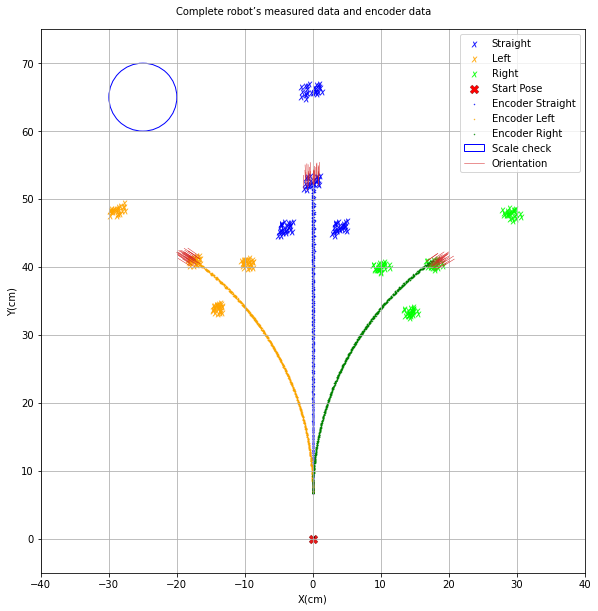

In [41]:
plot_compelete_data()

Team A data:600


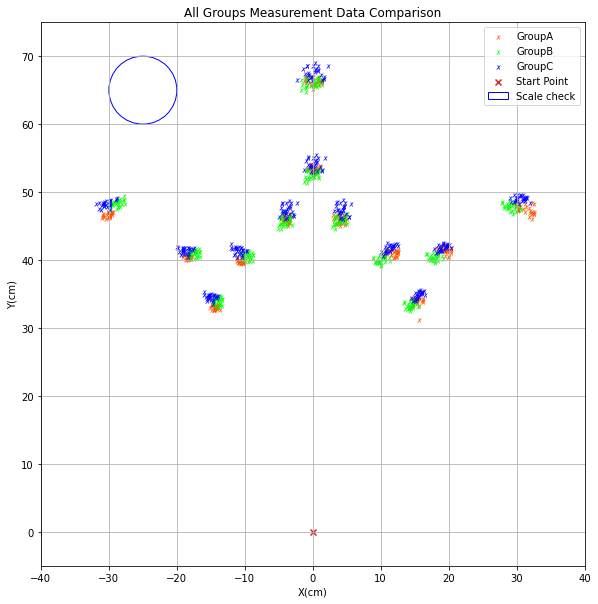

In [42]:
import numpy as np
import matplotlib.pyplot as plt

##For my Team Data
file = open("manual_data_with_centroid.txt", "r")
content =file.readlines()
data=''.join(content[0:75])
#print(f"my data:{data}")
reshaped_data = np.array([float(num) for num in data.split()]).reshape(300,2)
reshaped_data = np.round(reshaped_data, decimals=2)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
##For Team A
file_TeamA = open("Manual_data_with_centroid_TeamA.txt", "r")
content_TeamA =file_TeamA.readlines()
data_TeamA=''.join(content_TeamA[0:75])
#print(f"Team A data:{data_TeamA}")
reshaped_data_TeamA = np.array([float(num) for num in data_TeamA.split()]).reshape(300,2)
reshaped_data_TeamA = np.round(reshaped_data_TeamA, decimals=2)
print(f"Team A data:{reshaped_data_TeamA.size}")

##For Team C
file_TeamC = open("Manual_data_with_centroid_TeamC.txt", "r")
content_TeamC =file_TeamC.readlines()
data_TeamC=''.join(content_TeamC[0:75])
#print(f"Team A data:{data_TeamA}")
reshaped_data_TeamC = np.array([float(num) for num in data_TeamC.split()]).reshape(300,2)
reshaped_data_TeamC = np.round(reshaped_data_TeamC, decimals=2)
#print(f"Team A data:{reshaped_data_TeamA}")


plt.scatter(reshaped_data_TeamA[:,0],reshaped_data_TeamA[:,1],s=15,c='#ff5500',marker=r'$X$', linewidth=0.2)#,edgecolors='black')
plt.scatter(reshaped_data[:,0],reshaped_data[:,1],s=15,c='#00ff00',marker=r'$X$', linewidth=0.2)#,edgecolors='black')
plt.scatter(reshaped_data_TeamC[:,0],reshaped_data_TeamC[:,1],s=15,c='#0000ff',marker=r'$X$', linewidth=0.2)#,edgecolors='black')
plt.scatter(0,0,marker="x",c='#d62728')
circle1 = plt.Circle((-25, 65), 5, color='b', fill=False,  label = "Scale check")
plt.gca().add_patch(circle1)
plt.legend(['GroupA','GroupB','GroupC','Start Point', "Scale check"])    
plt.ylim(-5, 75)
plt.xlim(-40, 40)
plt.grid()
plt.xlabel("X(cm)")
plt.ylabel("Y(cm)")
plt.title("All Groups Measurement Data Comparison")
plt.show()

In [43]:
import math

file = open("manual_data_with_centroid.txt", "r")
content =file.readlines()
data=''.join(content[0:75])
reshaped_data = np.array([float(num) for num in data.split()]).reshape(75,8)
reshaped_data = np.round(reshaped_data, decimals=2)

centroid_orientation=[]
for data in reshaped_data:
    orientation=np.arctan2((data[1]-0.5*(data[3]+data[5])),(data[0]-0.5*(data[2]+data[4])))
    centroid_orientation.append(orientation)

centroid_orientation = np.array(centroid_orientation).reshape(75, 1)
reshaped_data = np.hstack((reshaped_data, centroid_orientation))


#### Marking Sheet

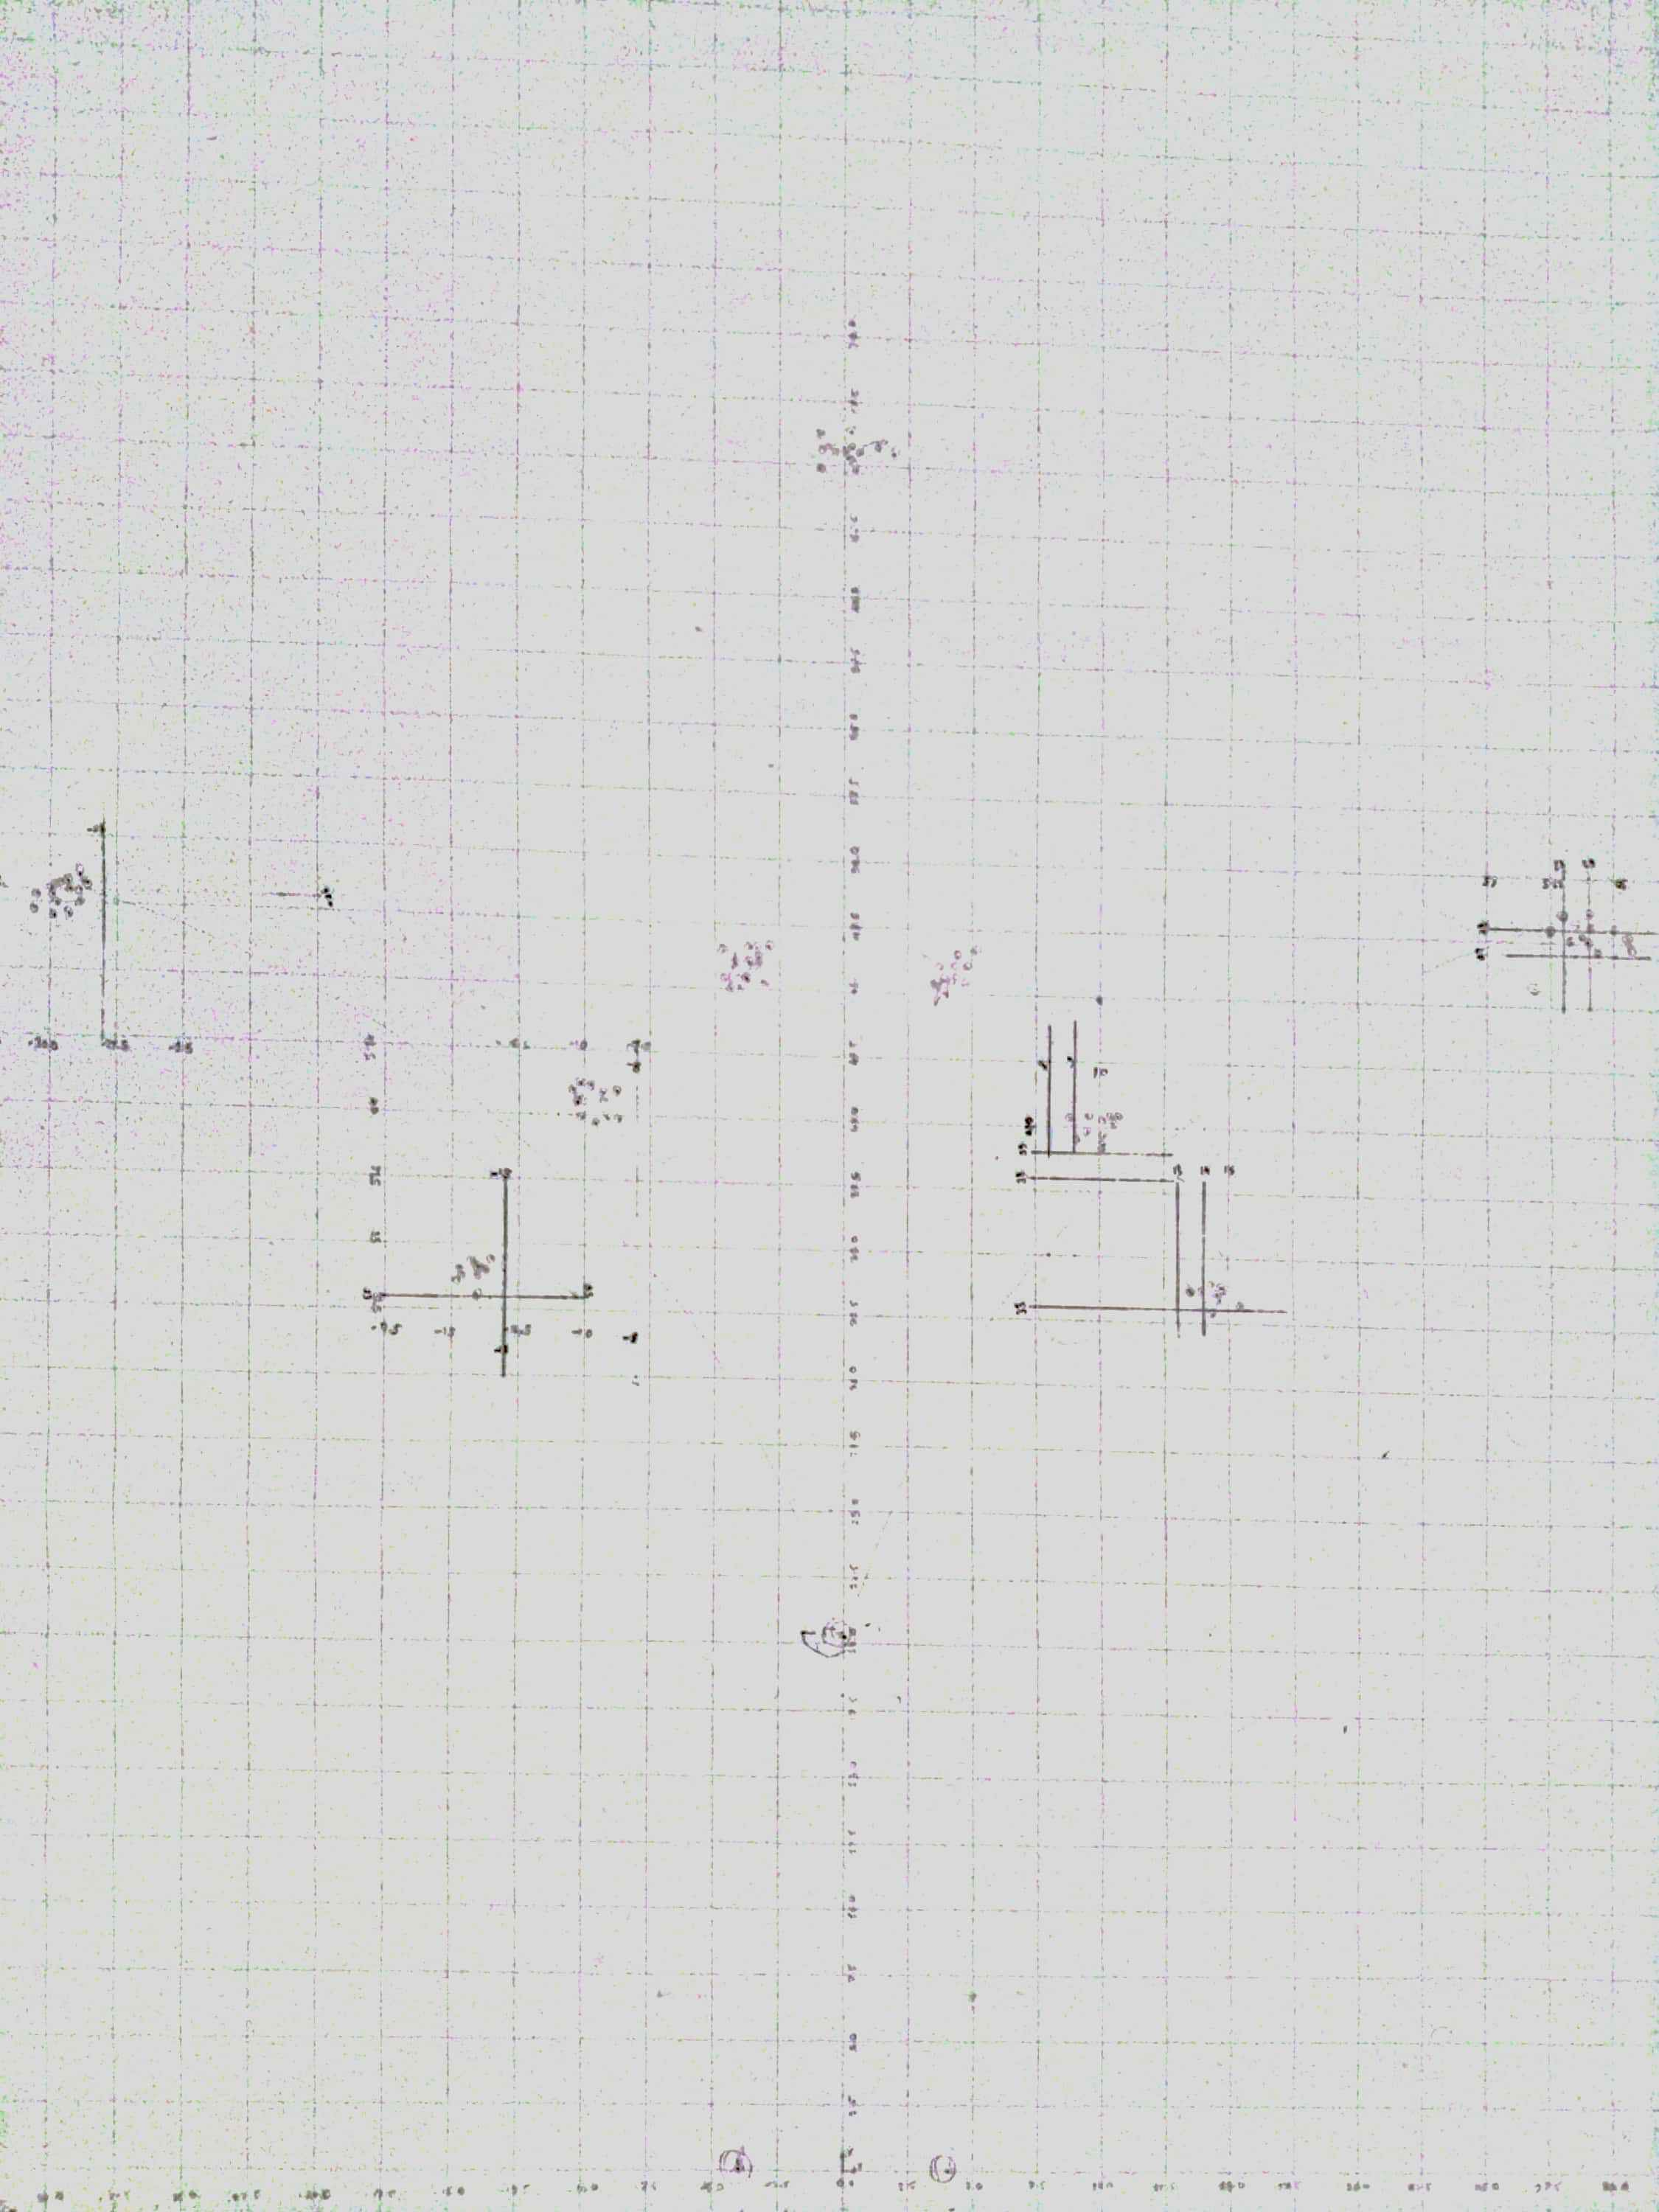

#### Videos showing robot’s behaviour


- Right: https://youtu.be/Q479tdKWaUw
- Left: https://youtu.be/JsIyYdCZZWE
- Straight: https://youtu.be/ch-Qr-5aa0o


## Assignment 3: Outlier Detection

To detect outliers we are using Bienyame-Chebyshev‘s theorem.  As we don't know probability distribution of the measured data and Chebyshev‘s theorem helps us to find minimum proportion of observations that fall within a particular number of standard deviation from the mean/expected value. So we can find outliers by only knowing mean/expected value and variance of the data. 

We detected outliers separately for front marker, real left marker and rear right marker in case of straight, left turn and right turn. Instead of calculating outliers separately for x and y co-ordinates, we are converting them into single value of euclidean distance. We are keeping initial likelihood as 0.25 and final likelihood as 0.01.

In [44]:
##This code rejects the outlier
def remove_outliers(data, pp1, pp2):
    '''
    Based on "Data Outlier Detection using the Chebyshev Theorem",
    Brett G. Amidan, Thomas A. Ferryman, and Scott K. Cooley
    Keyword arguments:
    data -- A numpy array of discrete or continuous data
    pp1 -- likelihood of expected outliers (e.g., 0.1, 0.05 , 0.01)
    pp2 -- final likelihood of real outliers (e.g., 0.01, 0.001 , 0.0001)
    '''
    ### phase 1
    mu1 = np.mean(data)
    sigma1 = np.std(data)
    k = 1./ np.sqrt(pp1)
    odv1u = mu1 + k * sigma1
    odv1l = mu1 - k * sigma1
    new_data=data[\
    np.where(data<= odv1u)[0]]
    new_data = new_data[\
    np.where(new_data >= odv1l)[0]]

    ### phase 2: calculate new u
    ### unbiased mu and sigma
    mu2 = np.mean(new_data)
    sigma2 = np.std(new_data)
    k = 1./ np.sqrt(pp2)
    odv2u = mu2 + k * sigma2
    odv2l = mu2 - k * sigma2
    final_data = new_data[\
    np.where(new_data <= odv2u)[0]]
    final_data = new_data[\
    np.where(final_data >= odv2l)[0]]


    return final_data

In [45]:
def apply_outlier_detection(data, point_index: tuple):
    dist_list=np.sqrt(data[:,point_index[0]]**2 + data[:,point_index[1]]**2)
    filtered_data=remove_outliers(dist_list,0.1,0.01)
    print()

    filtered_data_2d = []
    for i in range(len(filtered_data)):
        index=np.where(filtered_data[i]==dist_list)[0][0]
        filtered_data_2d.append([data[index, point_index[0]],data[index, point_index[1]]])
    
    filtered_data_2d=np.array(filtered_data_2d)
    return filtered_data_2d

In [46]:
def plot_outliers(data, description: str):

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    def subplot_outliers(axs, point_index: tuple, description: str):
        filtered_data_2d = apply_outlier_detection(data, point_index)
        axs.scatter(data[:,point_index[0]],data[:,point_index[1]], s=30,c='#ff0000',marker="X",edgecolors='black', linewidth=0.2, label = "Outlier")
        axs.scatter(filtered_data_2d[0::,0], filtered_data_2d[0::,1], s=30,c='#0000ff',marker="X",edgecolors='black', linewidth=0.2, label = "Data Points")
        
        # plot mean point
        x_mean = np.mean(data[:,point_index[0]])
        y_mean = np.mean(data[:,point_index[1]])
        axs.scatter([x_mean], [y_mean], s=50,c='#00ff44',marker="X",edgecolors='black', linewidth=0.2, label = "Mean Point")

        x_limits = axs.get_xlim()
        y_limits = axs.get_ylim()

        circle1 = plt.Circle((math.ceil(x_limits[0]) + 0.5, math.floor(y_limits[1]) - 0.5), 0.5, color='g', fill=False,  label = "Scale check")
        axs.add_patch(circle1)

        axs.set_title(description + str(len(data) - len(filtered_data_2d)))
        axs.set_xlabel("X(cm)")
        axs.set_ylabel("Y(cm)")
        axs.legend()
        axs.grid()
        axs.set_xlim([math.floor(x_mean) - 3.0, math.floor(x_mean) + 4.0])
        axs.set_ylim([math.floor(y_mean) - 3.0, math.floor(y_mean) + 4.0])
        axs.set_aspect('equal', adjustable="datalim")
        return axs
    
    axs[0] = subplot_outliers(axs[0], (0,1), f"Direction: {description}, Total number of Outliers for the Front Marker:")
    axs[1] = subplot_outliers(axs[1], (2,3), f"Direction: {description}, Total filtered Points for the Rear-Left Marker:")
    axs[2] = subplot_outliers(axs[2], (4,5), f"Direction: {description}, Total filtered Points for the Rear-Right Marker:")
    
    plt.tight_layout()
    plt.show()

In [47]:
def plot_normal_distribution(filtered_data_2d, description):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid of subplots

    # Plot for X-axis (first column of filtered_data_2d)
    x_data = filtered_data_2d[:, 0]  # Assuming X data is in the first column
    x_axis = np.arange(min(x_data) - 1, max(x_data) + 1, 0.01)
    n, bins, patches = axs[0].hist(x_data, bins=7, color='blue', edgecolor='k', label='X Histogram', density = True)
    
    mean_x = x_data.mean()
    sd_x = x_data.std()
    axs[0].plot(x_axis, norm.pdf(x_axis, mean_x, sd_x), color='red', label='X pdf')
    axs[0].set_title('Normal Distribution on X-axis for ' + description)
    axs[0].legend()
    axs[0].set_xlabel('x (cm)')
    axs[0].set_ylabel('Probability Density')
    axs[0].grid()
    x_limits = axs[0].get_xlim()
    axs[0].set_xlim([math.floor(x_limits[0]), math.ceil(x_limits[1])])

    axs[0].set_ylim([0, 1.5])

    # Plot for Y-axis (second column of filtered_data_2d)
    y_data = filtered_data_2d[:, 1]  # Assuming Y data is in the second column
    y_axis = np.arange(min(y_data) - 1, max(y_data) + 1, 0.01)
    n, bins, patches = axs[1].hist(y_data, bins=7, color='green', edgecolor='k', label='Y Histogram', density = True)
    
    mean_y = y_data.mean()
    sd_y = y_data.std()
    axs[1].plot(y_axis, norm.pdf(y_axis, mean_y, sd_y), color='red', label='Y pdf')
    axs[1].set_title('Normal Distribution on Y-axis for ' + description)
    axs[1].legend()
    axs[1].set_xlabel('y (cm)')
    axs[1].set_ylabel('Probability Density')
    axs[1].grid()
    x_limits = axs[1].get_xlim()
    axs[1].set_xlim([math.floor(x_limits[0]) , math.ceil(x_limits[1])])
    axs[1].set_ylim([0, 1.5])

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

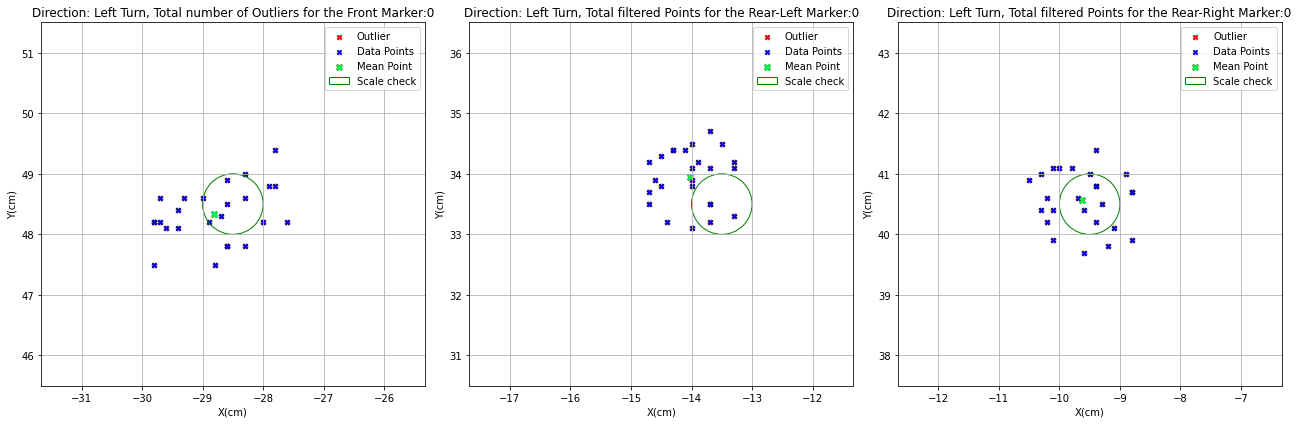

In [48]:
plot_outliers(reshaped_data[25:50], "Left Turn")

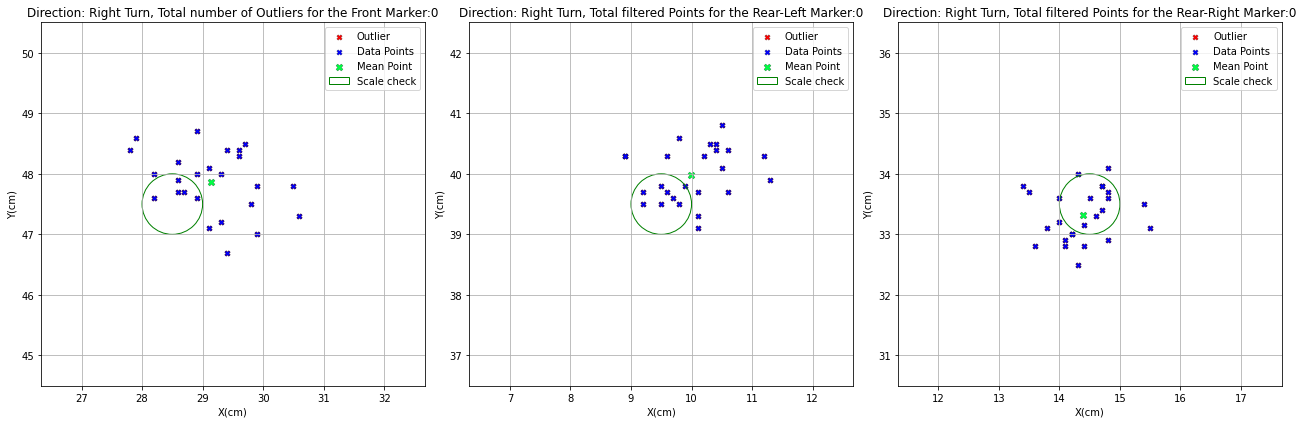

In [49]:
plot_outliers(reshaped_data[50:75], "Right Turn")

### Normal Distribution for Centroids

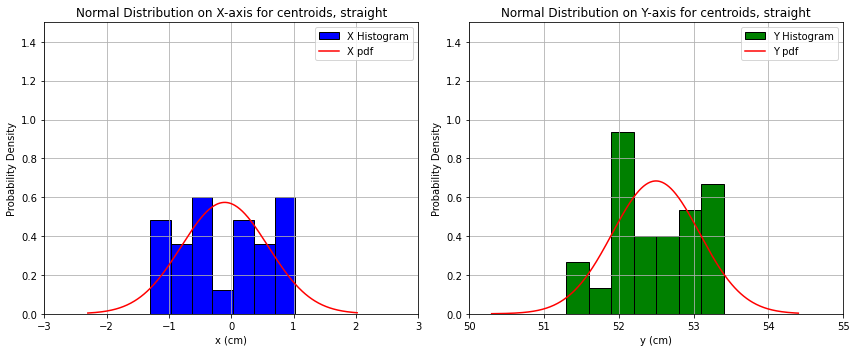

In [50]:
filtered_data = apply_outlier_detection(reshaped_data[0:25], (6,7))
plot_normal_distribution(filtered_data, "centroids, straight")

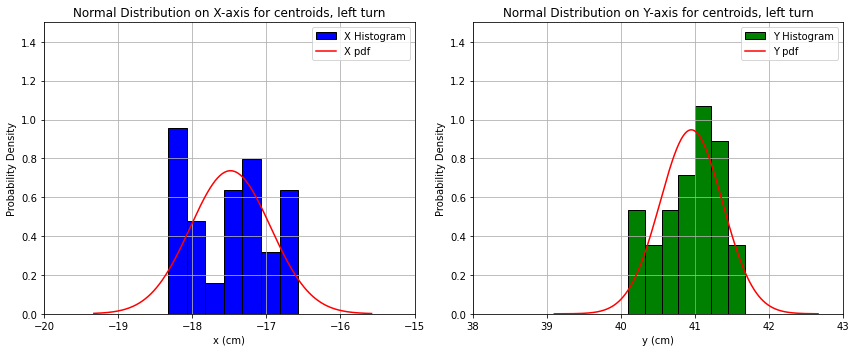

In [51]:
filtered_data = apply_outlier_detection(reshaped_data[25:50], (6,7))
plot_normal_distribution(filtered_data, "centroids, left turn")

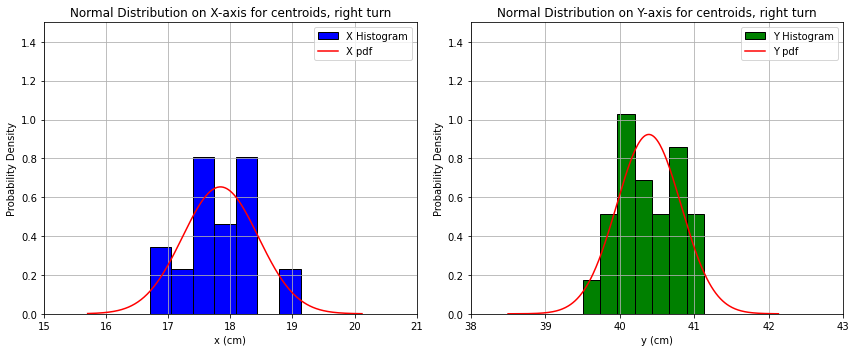

In [52]:
filtered_data = apply_outlier_detection(reshaped_data[50:75], (6,7))
plot_normal_distribution(filtered_data, "centroids, right turn")

### Data Analysis
Question: When analysing the data with respect to the executed motions, which characteristic of the data do you establish here: the accuracy, the precision, or both?

Answer: Accuracy refers to how close the measured value is to the true value or target. While precision refers to how close the measurements are. In our set of experiments the measurement readings are closer to each other and we remove the readings which are far from the mean value using outlier detection. This means we keep the precise data and remove imprecise data. So in our experiments we establish precision of the data.

### Analysis of Statistical Parameters

In this section, we are calculating mean and variance of the measured data; We are also calculating the p_value of the measured data using the Lilliefors test.

The Lilliefors test is a statistical test used to determine whether a sample comes from a normally distributed population. It is an adaptation of the Kolmogorov-Smirnov test, which compares the empirical distribution function of a sample with the expected cumulative distribution function of a normal distribution.

In our evaluation, we set the significance level ($\alpha$) as 0.05. If p_value is greater than $\alpha$, we conclude that evidence given is not strong enough to reject the hypothesis.

In [53]:
#Statistical evaluation of Straight
import pandas as pd
import statsmodels.api as sm


centroid_straight=[]

filtered_data_front_straight = apply_outlier_detection(reshaped_data[0:25], (0,1))
filtered_data_RL_straight = apply_outlier_detection(reshaped_data[0:25], (2,3))
filtered_data_RR_straight = apply_outlier_detection(reshaped_data[0:25], (4,5))

for i in range(len(filtered_data_front_straight[:,0])):
    x_avg=filtered_data_front_straight[i,0]+filtered_data_RL_straight[i,0]+filtered_data_RR_straight[i,0]
    y_avg=filtered_data_front_straight[i,1]+filtered_data_RL_straight[i,1]+filtered_data_RR_straight[i,1]
    orientation=np.arctan2((filtered_data_front_straight[i,1]-0.5*(filtered_data_RL_straight[i,1]+filtered_data_RR_straight[i,1])),(filtered_data_front_straight[i,0]-0.5*(filtered_data_RL_straight[i,0]+filtered_data_RR_straight[i,0])))
    centroid_straight.append([x_avg,y_avg,orientation])

centroid_straight=np.array(centroid_straight)

ksstat_straight_x, pvalue_straight_x = sm.stats.diagnostic.lilliefors(centroid_straight[:,0])
ksstat_straight_y, pvalue_straight_y = sm.stats.diagnostic.lilliefors(centroid_straight[:,1])
ksstat_straight_theta, pvalue_straight_theta = sm.stats.diagnostic.lilliefors(centroid_straight[:,2])

#print(pvalue_straight_x,pvalue_straight_y,pvalue_straight_theta)

data = {
    'Statistic': ['Mean', 'Variance', 'Test Statistic', 'p-value', 'Null Hypothesis'],
    'Centroid X': [
        f"{centroid_straight[:, 0].mean():.1f} cm",  # Mean with "cm"
        f"{np.var(centroid_straight[:, 0]):.1f} cm²",  # Variance with "cm²"
        ksstat_straight_x, 
        pvalue_straight_x, 
        'Reject' if pvalue_straight_x < 0.05 else "Can't reject"
    ],
    'Centroid Y': [
        f"{centroid_straight[:, 1].mean():.1f} cm",  # Mean with "cm"
        f"{np.var(centroid_straight[:, 1]):.1f} cm²",  # Variance with "cm²"
        ksstat_straight_y, 
        pvalue_straight_y, 
        'Reject' if pvalue_straight_y < 0.05 else "Can't reject"
    ],
    'Centroid Orientation': [
        f"{centroid_straight[:, 2].mean():.2f} rad", 
        f"{np.var(centroid_straight[:, 2]):.2f} rad²" , 
        f"{ksstat_straight_theta:.1f}", 
        f"{pvalue_straight_theta:.1f}", 
        'Reject' if pvalue_straight_theta < 0.05 else "Can't reject"
    ]
}

summary_table_straight = pd.DataFrame(data)


# Format the last column ('Centroid Orientation') to three decimal places for numerical values
summary_table_straight = style_frame(summary_table_straight, "Analysis of Statistical Parameters on Straight Motion")

In [54]:
display(summary_table_straight)

,Statistic,Centroid X,Centroid Y,Centroid Orientation
0,Mean,-0.3 cm,157.5 cm,1.58 rad
1,Variance,4.4 cm²,3.1 cm²,0.00 rad²
2,Test Statistic,0.1,0.1,0.2
3,p-value,0.5,0.2,0.1
4,Null Hypothesis,Can't reject,Can't reject,Can't reject


In [55]:
#Statistical evaluation of Left

filtered_data_front_left = apply_outlier_detection(reshaped_data[25:50], (0,1))
filtered_data_RL_left = apply_outlier_detection(reshaped_data[25:50], (2,3))
filtered_data_RR_left = apply_outlier_detection(reshaped_data[25:50], (4,5))


centroid_left=[]
for i in range(len(filtered_data_front_left[:,0])):
    x_avg=filtered_data_front_left[i,0]+filtered_data_RL_left[i,0]+filtered_data_RR_left[i,0]
    y_avg=filtered_data_front_left[i,1]+filtered_data_RL_left[i,1]+filtered_data_RR_left[i,1]
    orientation=np.arctan2((filtered_data_front_left[i,1]-0.5*(filtered_data_RL_left[i,1]+filtered_data_RR_left[i,1])),(filtered_data_front_left[i,0]-0.5*(filtered_data_RL_left[i,0]+filtered_data_RR_left[i,0])))

    centroid_left.append([x_avg,y_avg,orientation])

centroid_left=np.array(centroid_left)

ksstat_left_x, pvalue_left_x = sm.stats.diagnostic.lilliefors(centroid_left[:,0])
ksstat_left_y, pvalue_left_y = sm.stats.diagnostic.lilliefors(centroid_left[:,1])
ksstat_left_theta, pvalue_left_theta = sm.stats.diagnostic.lilliefors(centroid_left[:,2])

#print(pvalue_left_x,pvalue_left_y, pvalue_left_theta)

data = {
    'Statistic': ['Mean', 'Variance', 'Test Statistic', 'p-value', 'Null Hypothesis'],
    'Centroid X': [
        f"{centroid_left[:, 0].mean():.1f} cm",  # Mean with "cm"
        f"{np.var(centroid_left[:, 0]):.1f} cm²",  # Variance with "cm²"
        ksstat_left_x, 
        pvalue_left_x, 
        'Reject' if pvalue_left_x < 0.05 else "Can't reject"
    ],
    'Centroid Y': [
        f"{centroid_left[:, 1].mean():.1f} cm",  # Mean with "cm"
        f"{np.var(centroid_left[:, 1]):.1f} cm²",  # Variance with "cm²"
        ksstat_left_y, 
        pvalue_left_y, 
        'Reject' if pvalue_left_y < 0.05 else "Can't reject"
    ],
    'Centroid Orientation': [
        f"{centroid_left[:, 2].mean():.2f} rad", 
        f"{np.var(centroid_left[:, 2]):.2f} rad²" , 
        f"{ksstat_left_theta:.1f}", 
        f"{pvalue_left_theta:.1f}", 
        'Reject' if pvalue_left_theta < 0.05 else "Can't reject"
    ]
}

summary_table_left = pd.DataFrame(data)

summary_table_left = style_frame(summary_table_left, "Analysis of Statistical Parameters on Left Motion")

In [56]:
display(summary_table_left)


,Statistic,Centroid X,Centroid Y,Centroid Orientation
0,Mean,-52.5 cm,122.8 cm,2.56 rad
1,Variance,2.6 cm²,1.6 cm²,0.00 rad²
2,Test Statistic,0.2,0.1,0.1
3,p-value,0.1,0.5,0.6
4,Null Hypothesis,Can't reject,Can't reject,Can't reject


In [57]:
#Statistical evaluation of Right

filtered_data_front_right = apply_outlier_detection(reshaped_data[50:75], (0,1))
filtered_data_RL_right = apply_outlier_detection(reshaped_data[50:75], (2,3))
filtered_data_RR_right = apply_outlier_detection(reshaped_data[50:75], (4,5))


centroid_right=[]
for i in range(len(filtered_data_front_right[:,0])):
    x_avg=filtered_data_front_right[i,0]+filtered_data_RL_right[i,0]+filtered_data_RR_right[i,0]
    y_avg=filtered_data_front_right[i,1]+filtered_data_RL_right[i,1]+filtered_data_RR_right[i,1]
    orientation=np.arctan2((filtered_data_front_right[i,1]-0.5*(filtered_data_RL_right[i,1]+filtered_data_RR_right[i,1])),(filtered_data_front_right[i,0]-0.5*(filtered_data_RL_right[i,0]+filtered_data_RR_right[i,0])))
    centroid_right.append([x_avg,y_avg,orientation])

centroid_right=np.array(centroid_right)

ksstat_right_x, pvalue_right_x = sm.stats.diagnostic.lilliefors(centroid_right[:,0])
ksstat_right_y, pvalue_right_y = sm.stats.diagnostic.lilliefors(centroid_right[:,1])
ksstat_right_theta, pvalue_right_theta = sm.stats.diagnostic.lilliefors(centroid_right[:,2])

# print(pvalue_right_x,pvalue_right_y,pvalue_right_theta)

data = {
    'Statistic': ['Mean', 'Variance', 'Test Statistic', 'p-value', 'Null Hypothesis'],
    'Centroid X': [
        f"{centroid_right[:, 0].mean():.1f} cm",  # Mean with "cm"
        f"{np.var(centroid_right[:, 0]):.1f} cm²",  # Variance with "cm²"
        ksstat_right_x, 
        pvalue_right_x, 
        'Reject' if pvalue_right_x < 0.05 else "Can't reject"
    ],
    'Centroid Y': [
        f"{centroid_right[:, 1].mean():.1f} cm",  # Mean with "cm"
        f"{np.var(centroid_right[:, 1]):.1f} cm²",  # Variance with "cm²"
        ksstat_right_y, 
        pvalue_right_y, 
        'Reject' if pvalue_right_y < 0.05 else "Can't reject"
    ],
    'Centroid Orientation': [
        f"{centroid_right[:, 2].mean():.2f} rad", 
        f"{np.var(centroid_right[:, 2]):.2f} rad²" , 
        f"{ksstat_right_theta:.1f}", 
        f"{pvalue_right_theta:.1f}", 
        'Reject' if pvalue_right_theta < 0.05 else "Can't reject"
    ]
}

summary_table_right = pd.DataFrame(data)
summary_table_right = style_frame(summary_table_right, "Analysis of Statistical Parameters on Right Motion")

In [58]:
display(summary_table_right)

,Statistic,Centroid X,Centroid Y,Centroid Orientation
0,Mean,53.5 cm,121.2 cm,0.58 rad
1,Variance,3.4 cm²,1.7 cm²,0.00 rad²
2,Test Statistic,0.1,0.1,0.1
3,p-value,0.8,0.4,0.3
4,Null Hypothesis,Can't reject,Can't reject,Can't reject


# Assignment 5

## YouBot Placing Experiment

## Experimental Setup

---

<div class="row" style="text-align: center;">
    <div style="display: flex; justify-content: space-between; align-items: center; gap: 10px; width: 100%;">
        <figure style="flex: 1; margin: 0;">
            <img src="images/1.jpg" alt="Image 1" style="width: 100%; border: 2px solid #ccc;">
            <figcaption style="margin-top: 5px;">(a)</figcaption>
        </figure>
        <figure style="flex: 1; margin: 0;">
            <img src="images/2.jpg" alt="Image 2" style="width: 100%; border: 2px solid #ccc;">
            <figcaption style="margin-top: 5px;">(b)</figcaption>
        </figure>
        <figure style="flex: 1; margin: 0;">
            <img src="images/3.jpg" alt="Image 3" style="width: 100%; border: 2px solid #ccc;">
            <figcaption style="margin-top: 5px;">(c)</figcaption>
        </figure>
    </div>
    <p style="margin-top: 10px; font-size: 16px;">
       Images (a), (b), and (c) illustrate different view angles of the YouBot Setup for "YouBot Placing Experiment". 
    </p>
</div>



## Sources of Error
- In case of small object, the markers touch the end effector, which causes some disturbance(slight forward tilt) during pick and place.

- The large and medium objects were wobbling after the placing, the former more than the later.

- The fixture for initial position has some play in it, which can vary the start position.

- Blocking of the markers from the FoV of cameras can cause loss of tracking.

In [63]:
import pandas as pd

# Load the combined CSV file

def load_dataframe(path, pos_error = '± 0.5', ori_error = '± 0.02', unit = 'cm', ori_unit = "rad"):
    endpose_df = pd.read_csv(path)
    column_names = pd.MultiIndex.from_tuples([
        ('Left', f'x ({unit}) <br> {pos_error}'), ('Left', f'y ({unit}) <br> {pos_error}'), ('Left', f'orientation ({ori_unit}) <br> {ori_error}'),
        ('Straight', f'x ({unit}) <br> {pos_error}'), ('Straight', f'y ({unit}) <br> {pos_error}'), ('Straight', f'orientation ({ori_unit}) <br> {ori_error}'),
        ('Right', f'x ({unit}) <br> {pos_error}'), ('Right', f'y ({unit}) <br> {pos_error}'), ('Right', f'orientation ({ori_unit}) <br> {ori_error}')])
    
    endpose_df.columns = column_names
    return endpose_df

# Convert to a pandas DataFrame
# df = pd.DataFrame(endpose_small_df, columns = column_names)

def style_frame(df, description: str, ori_error = '± 0.02', ori_unit = "rad", manual_data = False):
    styled_df = df.style.set_table_styles(
    [{
        'selector': 'th, td',  # Select both table headers and cells
        'props': [('border', '2px solid black'),  ('text-align', 'center'), ('width', '2%')]  # Set a 2px solid black border
    },
        {
            'selector': 'caption',  
            'props': [
                ('caption-side', 'top'),
                ('text-align', 'center'),  
                ('font-weight', 'bold'),   
                ('font-size', '16px'),
                ('color', 'black')
            ]
        }]
    ).format(precision=1).set_properties(**{
    'width': '100%',
    'border-color': 'black',  # Border color for all table elements
    'border-width': '2px',
    'border-style': 'solid'
    }).set_caption(description)
    
    if manual_data:
        format_dict = {
            (side, f'orientation ({ori_unit}) <br> {ori_error}'): "{:.2f}"
            for side in ['Left', 'Straight', 'Right']
        }
        # Apply 1 decimal place to all other columns
        format_dict.update({
            col: "{:.1f}" for col in df.columns if col not in format_dict
        })
        
        styled_df = styled_df.format(format_dict)
    return styled_df

In [118]:
endpose_small_df = load_dataframe('effector/endpose_small.csv')
#display(style_frame(endpose_small_df, "End Effector End-pose measurements of Small object", True))


In [119]:
endpose_medium_df = load_dataframe('effector/endpose_medium.csv')
#display(style_frame(endpose_medium_df, "End Effector End-pose measurements of Medium object", True))

In [120]:
endpose_large_df = load_dataframe('effector/endpose_large.csv')
#display(style_frame(endpose_large_df, "End Effector End-pose measurements of Large object", True))

In [73]:
startpose_small_df = load_dataframe('effector/startpose_small.csv')
startpose_medium_df = load_dataframe('effector/startpose_medium.csv')
startpose_large_df = load_dataframe('effector/startpose_large.csv')
#print(startpose_small_df.mean())

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_endposes(endpose_df, title:str, pos_error = '± 0.5', ori_error = '± 0.02', unit = 'cm', ori_unit = 'rad'):    
    # Create a figure for the combined scatter plot
    plt.figure(figsize=(7, 7))
    plt.axis('equal')
    # Define a function to plot points and orientation lines for each motion
    def plot_motion(df, motion, color, label):
        # Scatter plot for the points
        plt.scatter(df[(motion, f'x ({unit}) <br> {pos_error}')], df[(motion, f'y ({unit}) <br> {pos_error}')], marker=r'$X$',
                    color=color, linewidth=0.2, label=label, alpha=0.6)
        
        # Plot orientation lines
        for x, y, orientation in zip(df[(motion, f'x ({unit}) <br> {pos_error}')], 
                                     df[(motion, f'y ({unit}) <br> {pos_error}')], 
                                     df[(motion, f'orientation ({ori_unit}) <br> {ori_error}')]):
            # Define length of the orientation line
            line_length = 2  # Adjustable length for visibility
            
            # Calculate end coordinates based on orientation angle
            x_end = x + line_length * np.cos(orientation)
            y_end = y + line_length * np.sin(orientation)
            
            # Plot the orientation line
            plt.plot([x, x_end], [y, y_end], color=color, alpha=0.6, linewidth=0.8)
    
    # Plot for each motion type
    plot_motion(endpose_df, 'Left', 'blue', 'Left')
    plot_motion(endpose_df, 'Straight', 'green', 'Straight')
    plot_motion(endpose_df, 'Right', 'red', 'Right')
    #plt.ylim(-70, -20)
    #plt.xlim(-10, 40)
    
    if unit == 'mm':
        circle1 = plt.Circle((-2650.0, 750.0), 50.0, color='green', fill=False,  label = "Scale check")
        plt.gca().add_patch(circle1) 
    else:
        circle1 = plt.Circle((-2.5, -22.5), 2.5, color='green', fill=False,  label = "Scale check")
        plt.gca().add_patch(circle1) 
        
    # Plot labels and title
    plt.xlabel(f'X-axis ({unit})')
    plt.ylabel(f'Y-axis ({unit})')
    plt.title(title)
    plt.gca().invert_xaxis()
    plt.grid()
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()


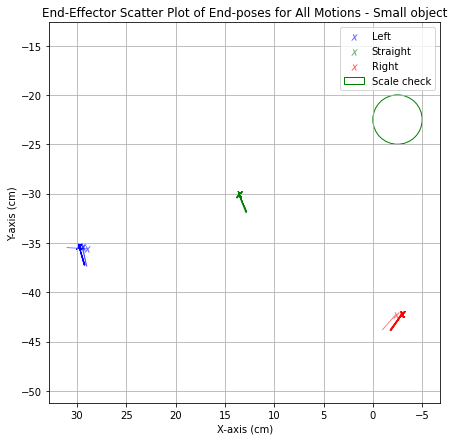

In [75]:
plot_endposes(endpose_small_df, "End-Effector Scatter Plot of End-poses for All Motions - Small object")

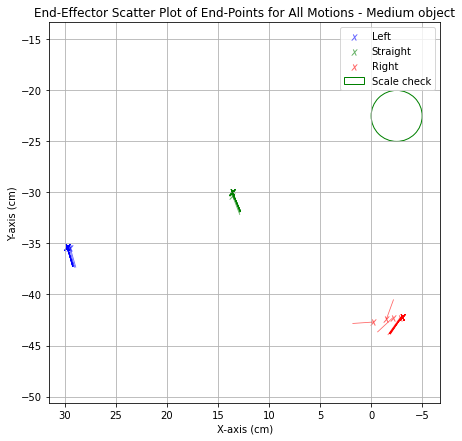

In [76]:
plot_endposes(endpose_medium_df, "End-Effector Scatter Plot of End-Points for All Motions - Medium object")

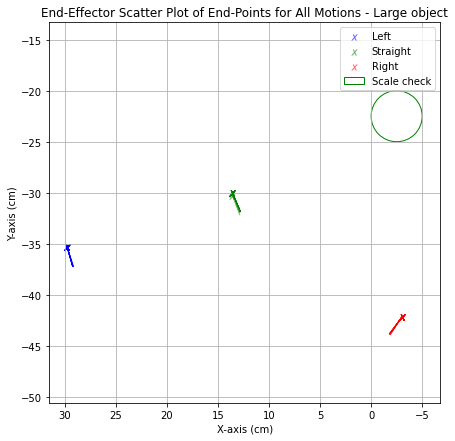

In [77]:
plot_endposes(endpose_large_df, "End-Effector Scatter Plot of End-Points for All Motions - Large object")

In [78]:
def plot_endeffector_all_motions():
    
    plt.figure(figsize=(10, 10))

    # Define a function to plot points and orientation lines for each motion
    def plot_all_motions(df, color, label):
        # Scatter plot for the points
        plt.scatter(df[('Left', 'x (cm) <br> ± 0.5')], df[('Left', 'y (cm) <br> ± 0.5')], marker=r'$X$',
                    color=color, linewidth=0.2, alpha=0.6)
        plt.scatter(df[('Straight', 'x (cm) <br> ± 0.5')], df[('Straight', 'y (cm) <br> ± 0.5')], marker=r'$X$',
                    color=color, linewidth=0.2, alpha=0.6)
        plt.scatter(df[('Right', 'x (cm) <br> ± 0.5')], df[('Right', 'y (cm) <br> ± 0.5')], marker=r'$X$',
                    color=color, label = label, linewidth=0.2, alpha=0.6)


        # Plot orientation lines
        def plot_orientation_lines(motion):
            for x, y, orientation in zip(df[(motion, 'x (cm) <br> ± 0.5')], 
                                         df[(motion, 'y (cm) <br> ± 0.5')], 
                                         df[(motion, 'orientation (rad) <br> ± 0.02')]):
                # Define length of the orientation line
                line_length = 2  # Adjustable length for visibility

                # Calculate end coordinates based on orientation angle
                x_end = x + line_length * np.cos(orientation)
                y_end = y + line_length * np.sin(orientation)
                plt.plot([x, x_end], [y, y_end], color=color, alpha=0.6, linewidth=0.8)

        plot_orientation_lines('Left')
        plot_orientation_lines('Straight')
        plot_orientation_lines('Right')


            # Plot the orientation line
    ""
    # Plot for each motion type
    plot_all_motions(endpose_medium_df, 'red', 'Medium Object')
    plot_all_motions(endpose_small_df, 'blue', 'Small Object')
    plot_all_motions(endpose_large_df, 'green', 'Large Object')

    plt.ylim(-70, -20)
    plt.xlim(-10, 40)
    # Plot labels and title
    
    circle1 = plt.Circle((-5.0, -25.0), 5.0, color='green', fill=False,  label = "Scale check")
    plt.gca().add_patch(circle1) 
    plt.xlabel('X-axis (cm)')
    plt.ylabel('Y-axis (cm)')

    plt.title("End-Effector Scatter Plot of End-Points for All Motions - All Objects")
    plt.grid()
    # Add a legend
    plt.legend()
    plt.gca().invert_xaxis()


    # Show the plot
    plt.show()


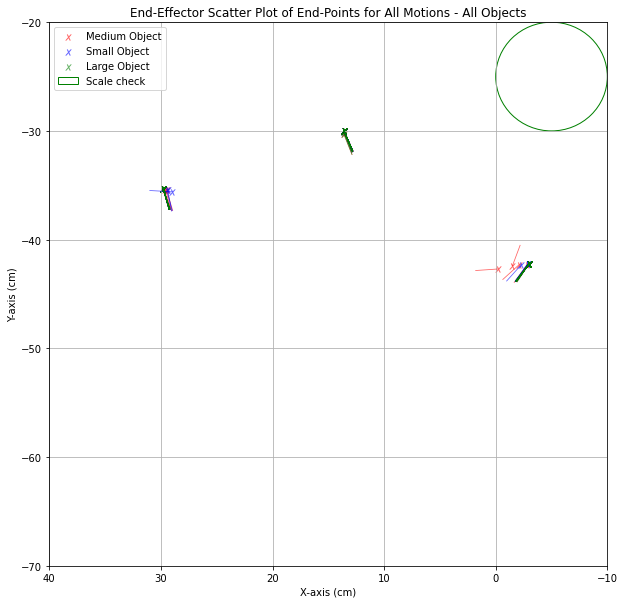

In [79]:
plot_endeffector_all_motions()

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


def plot_effector_path(motions, motion_prefixes, motion_color, description: str, size = 8):
    plt.figure(figsize=(size, size))    
    base_dir = os.path.join(os.getcwd(),"Group-2")
    num_trials = 25

    
    # Plot the data
    for motion in motions:
        for trial in range(1, num_trials + 1):
            file_path = os.path.join(base_dir, motion, 'csv', f"{motion_prefixes[motion]}{trial:02}.csv")
            data = pd.read_csv(file_path)
            data.columns = ['x', 'y', 'theta']
            # Scatter plot of x and y coordinates, with theta values as color
            plt.scatter(data['x'], data['y'], s = 0.2,  marker='o', color=motion_color[motion])
        
        
    for motion in motions:
        plt.scatter([], [], color=motion_color[motion], label=motion.replace("_", " ").capitalize())

    # Labeling the plot

    plt.xlim(-0.05, 0.35)
    plt.ylim(-0.60, -0.2)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    circle1 = plt.Circle((0.025, -0.275), 0.025, color='green', fill=False,  label = "Scale check")
    plt.gca().add_patch(circle1) 
    
    plt.title(description)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.grid(True)
    plt.gca().invert_xaxis()

    plt.legend()
    plt.show()


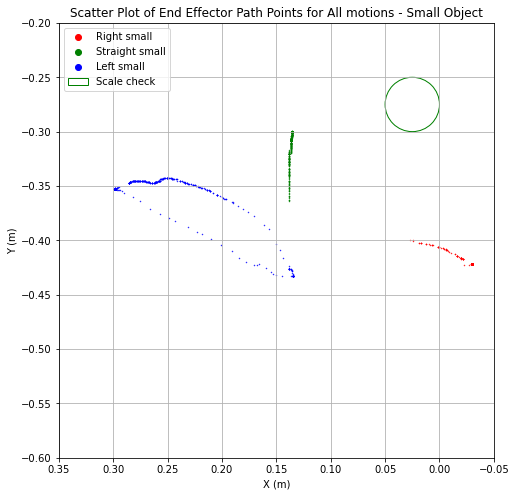

In [81]:
motions = {"left_small", "straight_small", "right_small"}
motion_prefixes = {"left_small": "ls_", "straight_small": "ss_", "right_small": "rs_"}
motion_color = {"left_small": "blue", "straight_small": "green", "right_small": "red"}
description = 'Scatter Plot of End Effector Path Points for All motions - Small Object'
plot_effector_path(motions, motion_prefixes, motion_color, description)

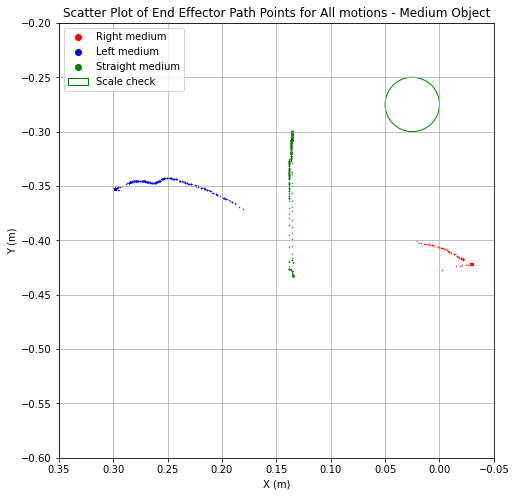

In [82]:
motions = {"left_medium", "straight_medium", "right_medium"}
motion_prefixes = {"left_medium": "lm_", "straight_medium": "sm_", "right_medium": "rm_"}
motion_color = {"left_medium": "blue", "straight_medium": "green", "right_medium": "red"}
description = 'Scatter Plot of End Effector Path Points for All motions - Medium Object'
plot_effector_path(motions, motion_prefixes, motion_color, description)

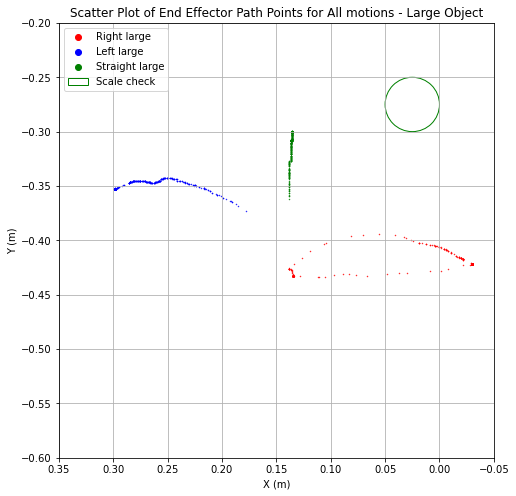

In [83]:
motions = {"left_large", "straight_large", "right_large"}
motion_prefixes = {"left_large": "ll_", "straight_large": "sl_", "right_large": "rl_"}
motion_color = {"left_large": "blue", "straight_large": "green", "right_large": "red"}
description = 'Scatter Plot of End Effector Path Points for All motions - Large Object'
plot_effector_path(motions, motion_prefixes, motion_color, description)

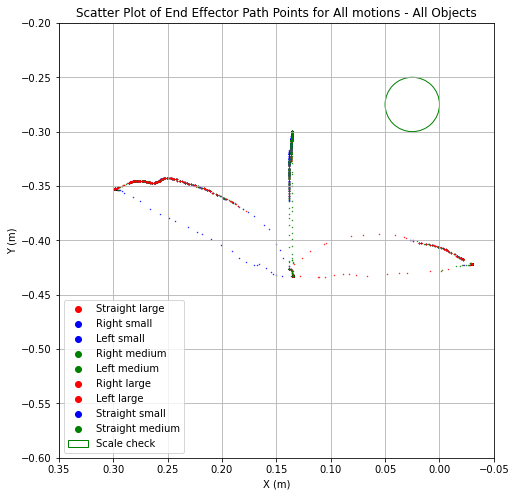

In [84]:
motions = {"left_small", "straight_small", "right_small", "left_medium", "straight_medium",
           "right_medium", "left_large", "straight_large", "right_large"}

motion_prefixes = {"left_small": "ls_", "straight_small": "ss_", "right_small": "rs_",
                   "left_medium": "lm_", "straight_medium": "sm_", "right_medium": "rm_",
                  "left_large": "ll_", "straight_large": "sl_", "right_large": "rl_"}

motion_color = {"left_small": "blue", "straight_small": "blue", "right_small": "blue", 
               "left_medium": "green", "straight_medium": "green", "right_medium": "green",
               "left_large":  "red", "straight_large":  "red", "right_large": "red"}

description = 'Scatter Plot of End Effector Path Points for All motions - All Objects'

plot_effector_path(motions, motion_prefixes, motion_color, description)

## OptiTrack Data

In [85]:
pos_error = '± 0.1'
ori_error = '± 0.01'
unit = 'mm'
ori_unit = 'degree'
optitrack_endpose_small_df = load_dataframe('start_end_pose_xz/S_final_pose.csv', pos_error , ori_error, unit, ori_unit)
display(style_frame(optitrack_endpose_small_df, "OptiTrack End-pose measurements of Small object", ori_error, ori_unit, True))

In [86]:
optitrack_endpose_medium_df = load_dataframe('start_end_pose_xz/M_final_pose.csv', pos_error, ori_error, unit, ori_unit)
display(style_frame(optitrack_endpose_medium_df, "OptiTrack End-pose measurements of Medium object", ori_error, ori_unit, True))

In [87]:
optitrack_endpose_large_df = load_dataframe('start_end_pose_xz/L_final_pose.csv', pos_error, ori_error, unit, ori_unit)
display(style_frame(optitrack_endpose_large_df, "OptiTrack End-pose measurements of Large object", ori_error, ori_unit, True))

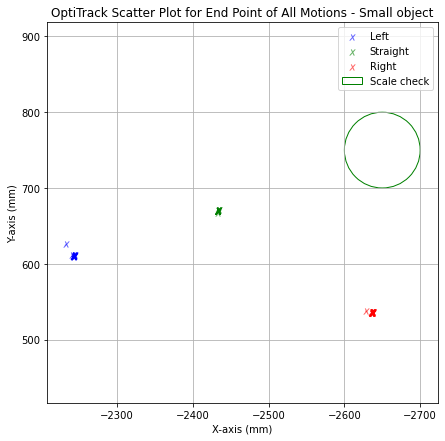

In [88]:
plot_endposes(optitrack_endpose_small_df, "OptiTrack Scatter Plot for End Point of All Motions - Small object", pos_error, ori_error, unit, ori_unit)

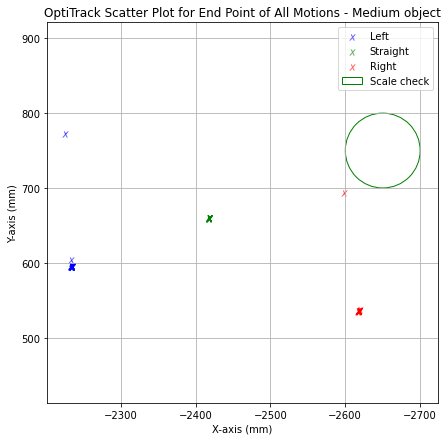

In [89]:
plot_endposes(optitrack_endpose_medium_df, "OptiTrack Scatter Plot for End Point of All Motions - Medium object", pos_error, ori_error, unit , ori_unit)

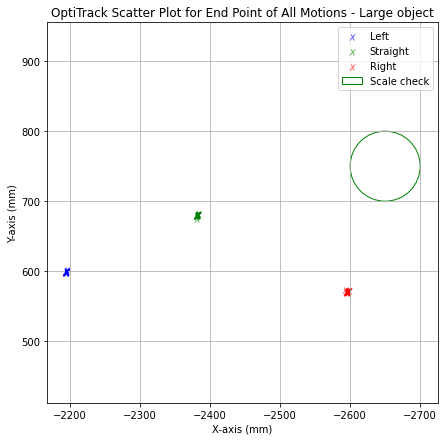

In [90]:
plot_endposes(optitrack_endpose_large_df, "OptiTrack Scatter Plot for End Point of All Motions - Large object", pos_error, ori_error, unit , ori_unit)

In [91]:
def plot_optitrack_all_motions(pos_error, ori_error):
    
    plt.figure(figsize=(10, 10))

    # Define a function to plot points and orientation lines for each motion
    def plot_all_motions(df, color, label):
        # Scatter plot for the points
        plt.scatter(df[('Left', f'x (mm) <br> {pos_error}')], df[('Left', f'y (mm) <br> {pos_error}')], marker=r'$X$',
                    color=color, linewidth=0.2, alpha=0.6)
        plt.scatter(df[('Straight', f'x (mm) <br> {pos_error}')], df[('Straight', f'y (mm) <br> {pos_error}')], marker=r'$X$',
                    color=color, linewidth=0.2, alpha=0.6)
        plt.scatter(df[('Right', f'x (mm) <br> {pos_error}')], df[('Right', f'y (mm) <br> {pos_error}')], marker=r'$X$',
                    color=color, label = label, linewidth=0.2, alpha=0.6)


        # Plot orientation lines
        def plot_orientation_lines(motion):
            for x, y, orientation in zip(df[(motion, f'x (mm) <br> {pos_error}')], 
                                         df[(motion, f'y (mm) <br> {pos_error}')], 
                                         df[(motion, f'orientation (degree) <br> {ori_error}')]):
                # Define length of the orientation line
                line_length = 2  # Adjustable length for visibility

                # Calculate end coordinates based on orientation angle
                x_end = x + line_length * np.cos(orientation)
                y_end = y + line_length * np.sin(orientation)
                plt.plot([x, x_end], [y, y_end], color=color, alpha=0.6, linewidth=0.8)

        plot_orientation_lines('Left')
        plot_orientation_lines('Straight')
        plot_orientation_lines('Right')


            # Plot the orientation line
    ""
    # Plot for each motion type
    plot_all_motions(optitrack_endpose_medium_df, 'red', 'Medium Object')
    plot_all_motions(optitrack_endpose_small_df, 'blue', 'Small Object')
    plot_all_motions(optitrack_endpose_large_df, 'green', 'Large Object')
    
    plt.xlim(-2700, -2100)
    plt.ylim(300, 900)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    circle1 = plt.Circle((-2650.0, 750.0), 50.0, color='green', fill=False,  label = "Scale check")
    plt.gca().add_patch(circle1) 
    
    # Plot labels and title
    plt.xlabel('X-axis (mm)')
    plt.ylabel('Y-axis (mm)')

    plt.title("OptiTrack Scatter Plot for End Point of All Motions - All Objects")
    plt.grid()
    # Add a legend
    plt.legend()
    plt.gca().invert_xaxis()

    # Show the plot
    plt.show()


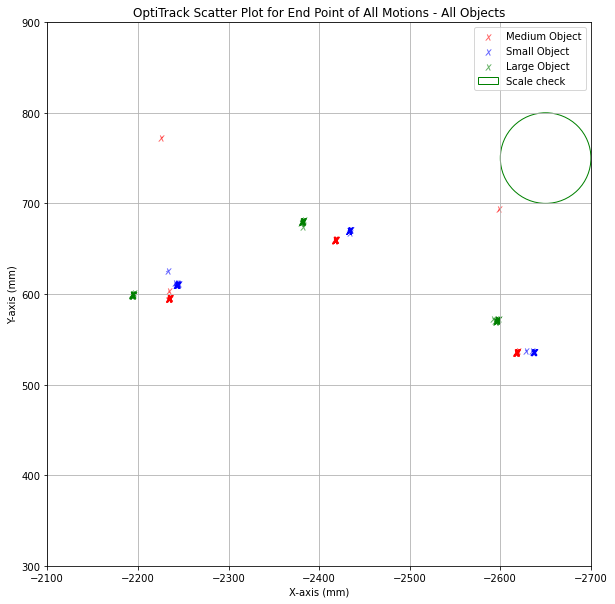

In [92]:
plot_optitrack_all_motions(pos_error, ori_error)

In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_effector_path(motions, motion_prefixes, motion_color, description: str, base_dir: str = './opti_track_data_new/opti_track_path'):
    """
    Plots end-effector paths for specified motions.

    Args:
        motions (set): Set of motion names (e.g., {"left_small", "straight_small", "right_small"}).
        motion_prefixes (dict): Mapping of motions to file prefixes (e.g., {"left_small": "ls_", ...}).
        motion_color (dict): Mapping of motions to plot colors.
        description (str): Title for the plot.
        base_dir (str): Base directory where processed CSV files are located.
    """
    plt.figure(figsize=(10, 10))

    # Iterate over specified motions
    for motion in motions:
        folder = motion_prefixes[motion]
        folder_path = os.path.join(base_dir, folder.upper())  # Assuming uppercase folder names (e.g., LL, LS, LR, etc.)
        
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        
        # Process each file in the motion folder
        for file in sorted(os.listdir(folder_path)):
            if file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                data = pd.read_csv(file_path)
                
                # Scatter plot for x and y
                plt.scatter(
                    data['x'], data['y'], s=2, color=motion_color[motion],
                    label=motion.replace("_", " ").capitalize() if file == sorted(os.listdir(folder_path))[0] else None
                )
    
    # Add legends for motions using an empty scatter for each motion
    for motion in motions:
        plt.scatter([], [], color=motion_color[motion], label=motion.replace("_", " ").capitalize())
    
    # Labeling the plot
    circle1 = plt.Circle((-2550.0, 750.0), 50.0, color='green', fill=False,  label = "Scale check")
    plt.gca().add_patch(circle1) 
    plt.ylim(350, 900)
    plt.xlim(-2650.0, -2100.0)
    plt.title(description)
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.gca().invert_xaxis()

    plt.grid(True)
    plt.legend()
    plt.show()

## Path trajectories by Opti Track

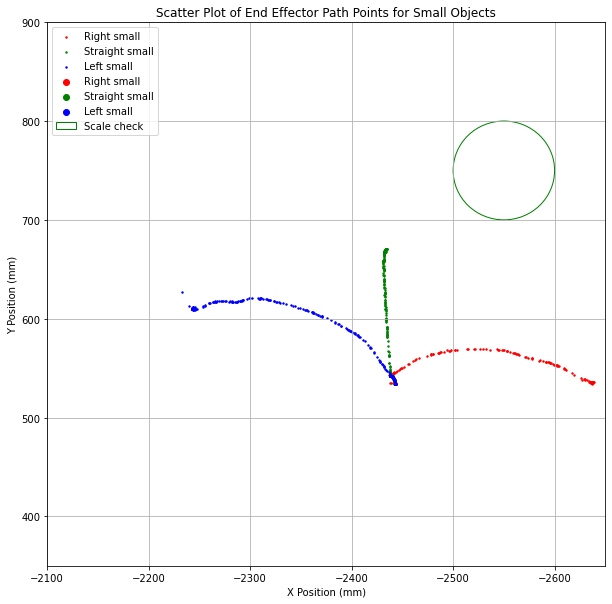

In [94]:
# Define parameters
base_dir = './opti_track_data_new/opti_track_path'  # Directory with processed CSV files

motions = {"left_small", "straight_small", "right_small"}
motion_prefixes = {"left_small": "SL", "straight_small": "SS", "right_small": "SR"}
motion_color = {"left_small": "blue", "straight_small": "green", "right_small": "red"}
description = 'Scatter Plot of End Effector Path Points for Small Objects'
plot_effector_path(motions, motion_prefixes, motion_color, description, base_dir)

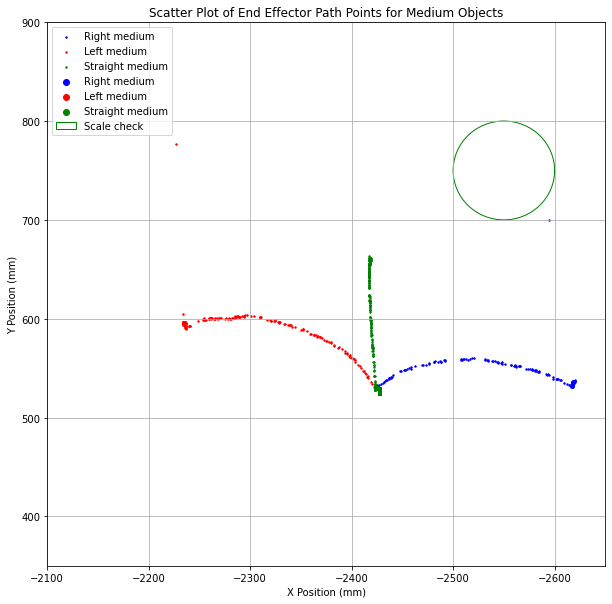

In [95]:
motions = {"left_medium", "straight_medium", "right_medium"}
motion_prefixes = {"left_medium": "ML", "straight_medium": "MS", "right_medium": "MR"}
motion_color = {"left_medium": "red", "straight_medium": "green", "right_medium": "blue"}
description = 'Scatter Plot of End Effector Path Points for Medium Objects'
plot_effector_path(motions, motion_prefixes, motion_color, description)

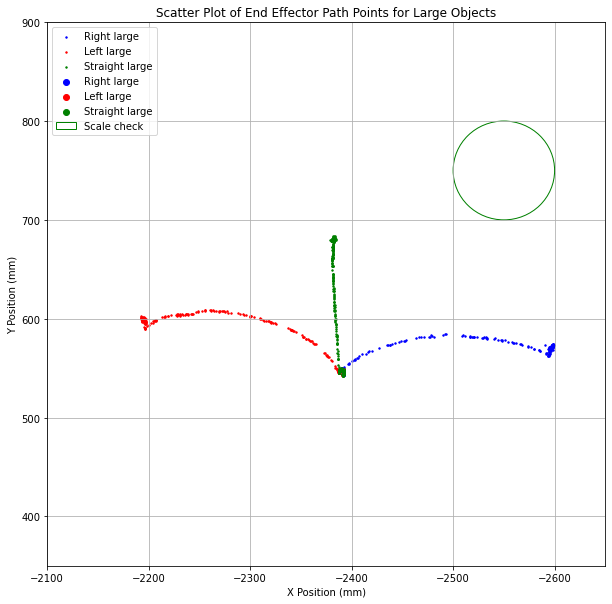

In [96]:
motions = {"left_large", "straight_large", "right_large"}
motion_prefixes = {"left_large": "LL", "straight_large": "LS", "right_large": "LR"}
motion_color = {"left_large": "red", "straight_large": "green", "right_large": "blue"}
description = 'Scatter Plot of End Effector Path Points for Large Objects'
plot_effector_path(motions, motion_prefixes, motion_color, description)

# Outlier Detection

In [97]:
def plot_outliers_optitrack(data, description: str):

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    def subplot_outliers(axs, point_index: tuple, description: str):
        filtered_data_2d = apply_outlier_detection(data, point_index)
        axs.scatter(data[:,point_index[0]],data[:,point_index[1]], s=30,c='#ff0000',marker=r'$X$',edgecolors='black', linewidth=0.2, label = "Outlier")
        axs.scatter(filtered_data_2d[0::,0], filtered_data_2d[0::,1], s=30,c='#0000ff',marker=r'$X$',edgecolors='black', linewidth=0.2, label = "Data Points")
        
        # plot mean point
        x_mean = np.mean(data[:,point_index[0]])
        y_mean = np.mean(data[:,point_index[1]])
        axs.scatter([x_mean], [y_mean], s=50,c='#00ff44',marker="X",edgecolors='black', linewidth=0.2, label = "Mean Point")

        x_limits = axs.get_xlim()
        y_limits = axs.get_ylim()

        circle1 = plt.Circle((math.ceil((x_mean // 25) * 25 + 62.5), math.floor((y_mean // 25) * 25  + 62.5)), 12.5, color='g', fill=False,  label = "Scale check")
        axs.add_patch(circle1)

        axs.set_title(description + str(len(data) - len(filtered_data_2d)))
        axs.set_xlabel("X(mm)")
        axs.set_ylabel("Y(mm)")
        axs.legend()
        axs.grid()
        
        axs.set_xlim([math.floor(int(x_mean)) - 100.0, math.floor(int(x_mean)) + 105.0])
        axs.set_ylim([math.floor(int(y_mean)) - 30.0, math.floor(int(y_mean)) + 175.0])
        axs.set_aspect('equal')
        return axs
    
    axs[0] = subplot_outliers(axs[0], (0,1), f"Object: {description}, Total number of Outliers for the Left:")
    axs[1] = subplot_outliers(axs[1], (3,4), f"Object: {description}, Total filtered Points for the Straight:")
    axs[2] = subplot_outliers(axs[2], (6,7), f"Object: {description}, Total filtered Points for the Right:")
    
    plt.tight_layout()
    plt.show()

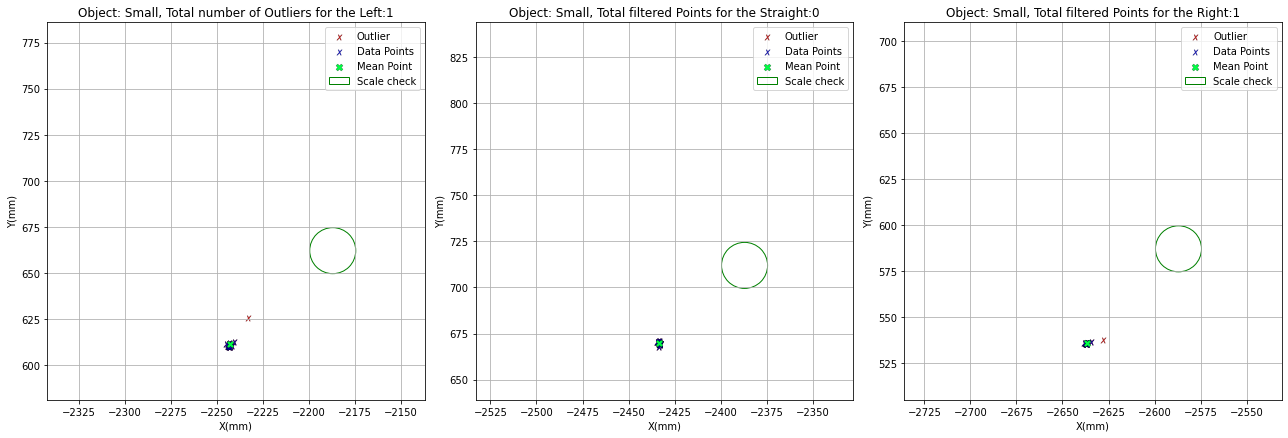

In [98]:
plot_outliers_optitrack(np.array(optitrack_endpose_small_df), "Small")

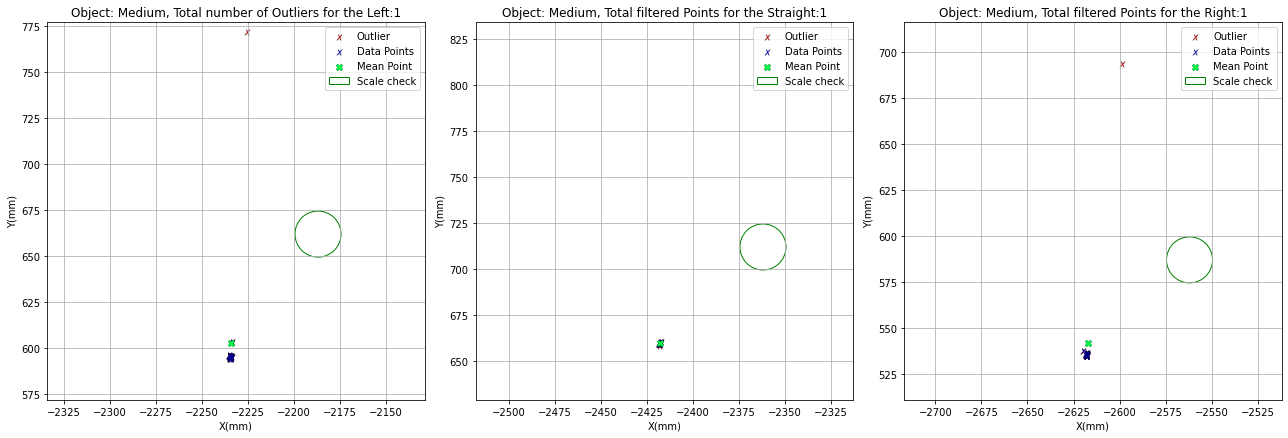

In [99]:
plot_outliers_optitrack(np.array(optitrack_endpose_medium_df), "Medium")

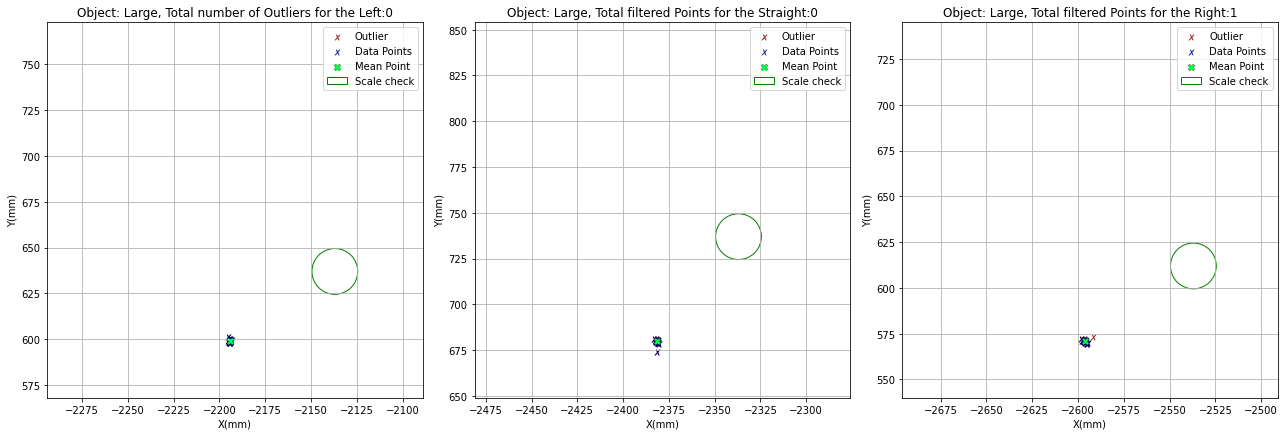

In [100]:
plot_outliers_optitrack(np.array(optitrack_endpose_large_df), "Large")

## Normal Distribution Plotting

Assignment 6 starts here

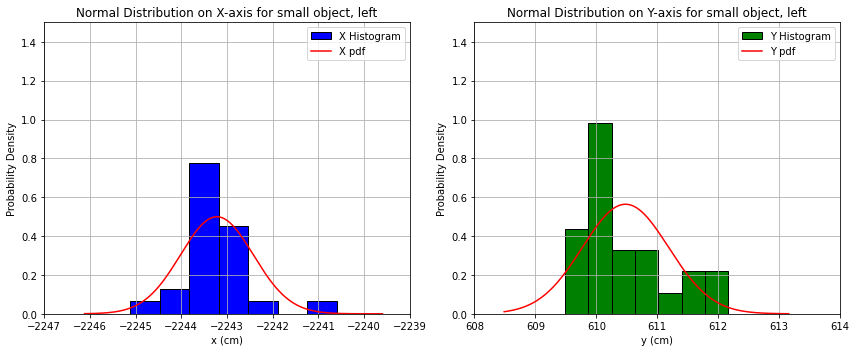

In [101]:
filtered_optitrack_endpose_small_left = apply_outlier_detection(np.array(optitrack_endpose_small_df), (0,1))
plot_normal_distribution(filtered_optitrack_endpose_small_left, "small object, left")

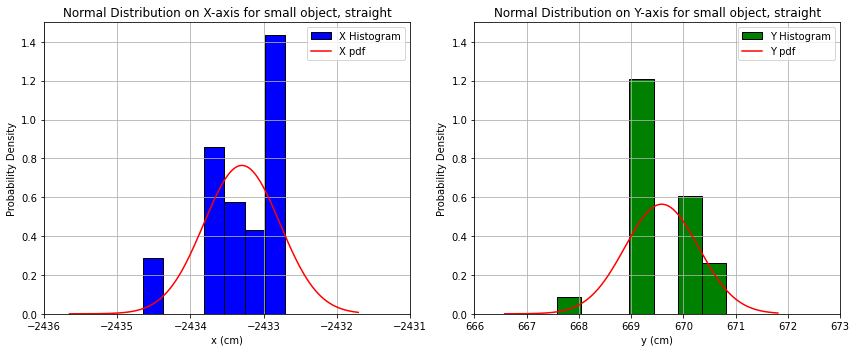

In [102]:
filtered_optitrack_endpose_small_straight = apply_outlier_detection(np.array(optitrack_endpose_small_df), (3,4))
plot_normal_distribution(filtered_optitrack_endpose_small_straight, "small object, straight")

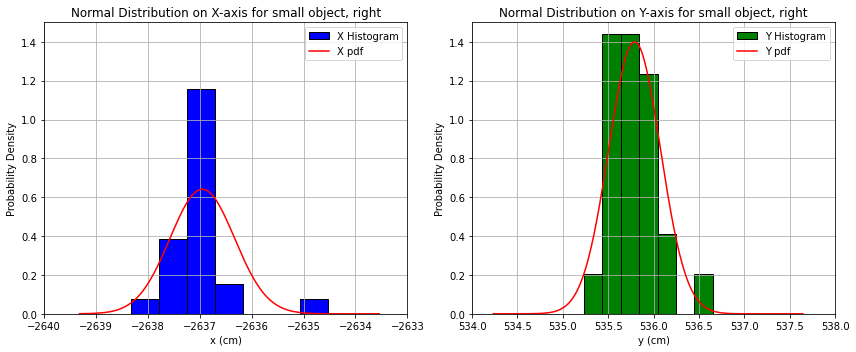

In [103]:
filtered_optitrack_endpose_small_right = apply_outlier_detection(np.array(optitrack_endpose_small_df), (6,7))
plot_normal_distribution(filtered_optitrack_endpose_small_right, "small object, right")

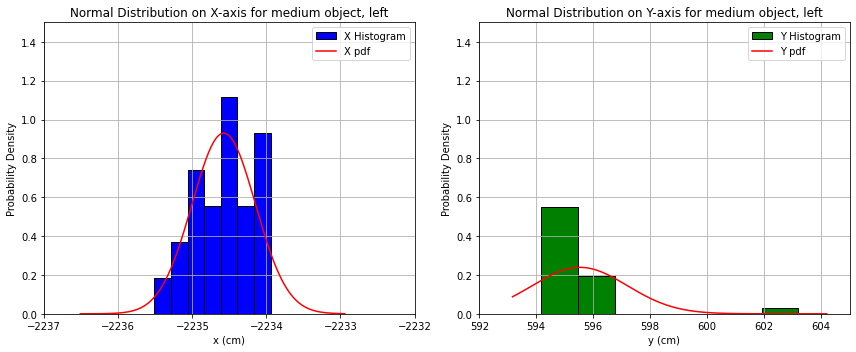

In [104]:
filtered_optitrack_endpose_medium_left = apply_outlier_detection(np.array(optitrack_endpose_medium_df), (0,1))
plot_normal_distribution(filtered_optitrack_endpose_medium_left, "medium object, left")

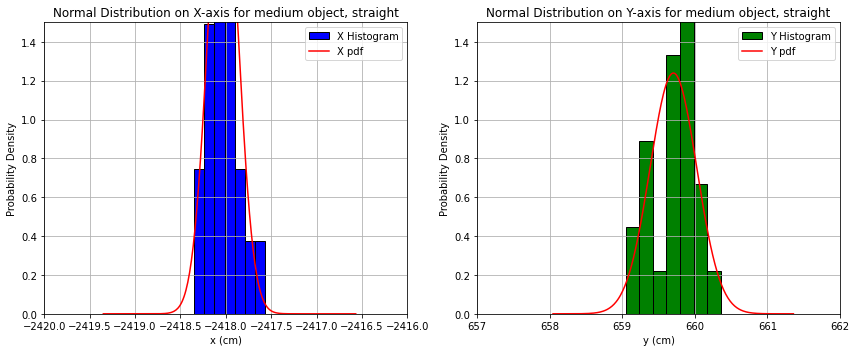

In [105]:
filtered_optitrack_endpose_medium_straight = apply_outlier_detection(np.array(optitrack_endpose_medium_df), (3,4))
plot_normal_distribution(filtered_optitrack_endpose_medium_straight, "medium object, straight")

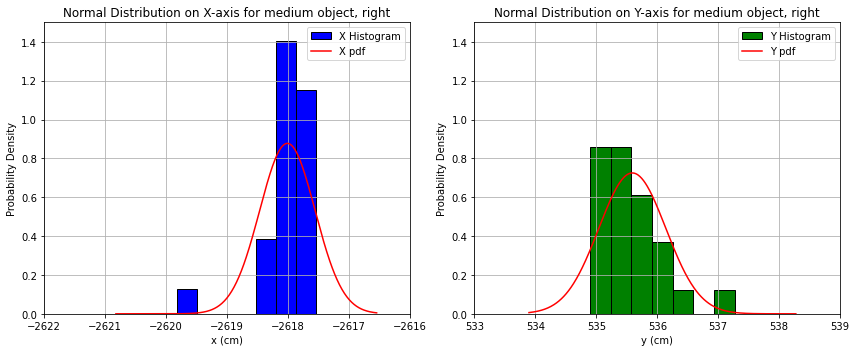

In [106]:
filtered_optitrack_endpose_medium_right = apply_outlier_detection(np.array(optitrack_endpose_medium_df), (6,7))
plot_normal_distribution(filtered_optitrack_endpose_medium_right, "medium object, right")

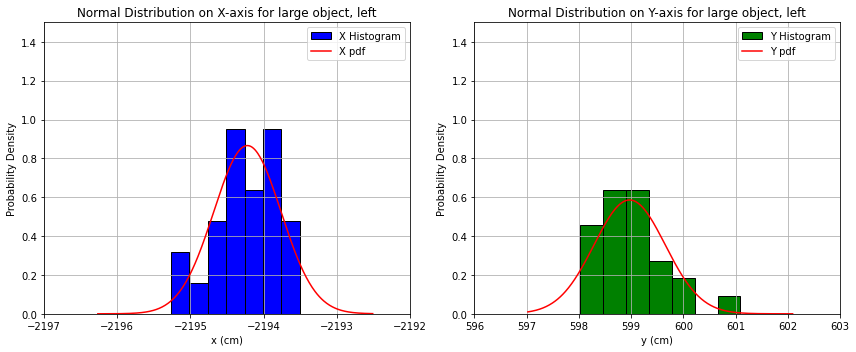

In [107]:
filtered_optitrack_endpose_large_left = apply_outlier_detection(np.array(optitrack_endpose_large_df), (0,1))
plot_normal_distribution(filtered_optitrack_endpose_large_left, "large object, left")

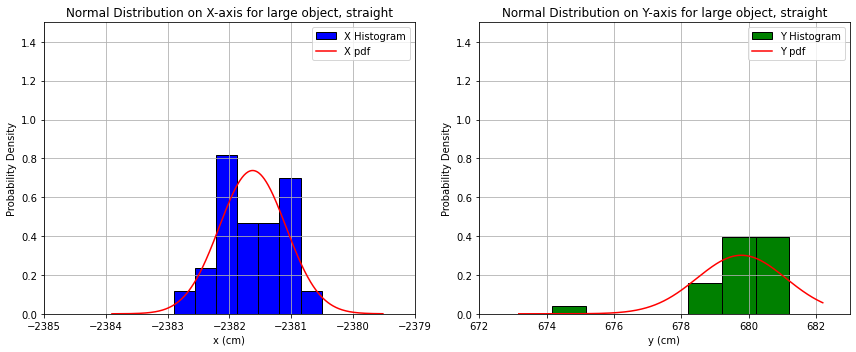

In [108]:
filtered_optitrack_endpose_large_straight = apply_outlier_detection(np.array(optitrack_endpose_large_df), (3,4))
plot_normal_distribution(filtered_optitrack_endpose_large_straight, "large object, straight")

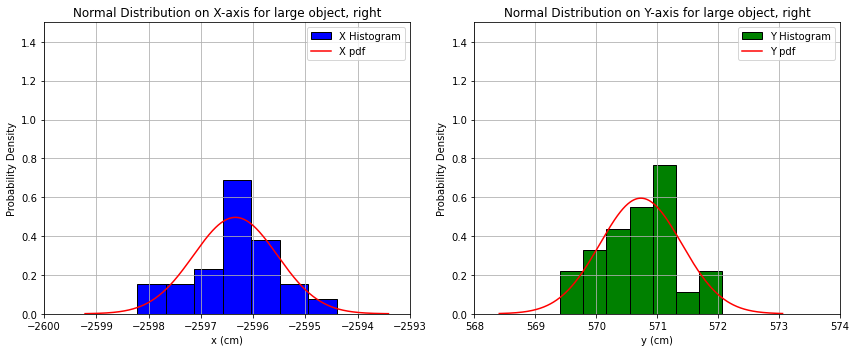

In [109]:
filtered_optitrack_endpose_large_right = apply_outlier_detection(np.array(optitrack_endpose_large_df), (6,7))
plot_normal_distribution(filtered_optitrack_endpose_large_right, "large object, right")

# Assignment 6

##  YouBot Placing Experiment: Data Analysis



In [110]:
def statistical_analysis(data_left,data_straight,data_right):

    ksstat_left_x, pvalue_left_x = sm.stats.diagnostic.lilliefors(data_left[:,0])
    ksstat_left_y, pvalue_left_y = sm.stats.diagnostic.lilliefors(data_left[:,1])
    #ksstat_left_theta, pvalue_left_theta = sm.stats.diagnostic.lilliefors(data[:,2])

    ksstat_straight_x, pvalue_straight_x = sm.stats.diagnostic.lilliefors(data_straight[:,0])
    ksstat_straight_y, pvalue_straight_y = sm.stats.diagnostic.lilliefors(data_straight[:,1])
    #ksstat_straight_theta, pvalue_straight_theta = sm.stats.diagnostic.lilliefors(data[:,5])

    ksstat_right_x, pvalue_right_x = sm.stats.diagnostic.lilliefors(data_right[:,0])
    ksstat_right_y, pvalue_right_y = sm.stats.diagnostic.lilliefors(data_right[:,1])
    #ksstat_right_theta, pvalue_right_theta = sm.stats.diagnostic.lilliefors(data[:,8])
    
    
    table_data = {
        'Statistic': ['Mean', 'Variance', 'Test Statistic', 'p-value', 'Null Hypothesis'],
        'Left X': [
            f"{data_left[:, 0].mean():.1f} mm",  # Mean with "mm"
            f"{np.var(data_left[:, 0]):.1f} mm²",  # Variance with "mm²"
            ksstat_left_x, 
            pvalue_left_x, 
            'Reject' if pvalue_left_x < 0.05 else "Can't reject"
        ],
        'Left Y': [
            f"{data_left[:, 1].mean():.1f} mm",  # Mean with "mm"
            f"{np.var(data_left[:, 1]):.1f} mm²",  # Variance with "mm²"
            ksstat_left_y, 
            pvalue_left_y, 
            'Reject' if pvalue_left_y < 0.05 else "Can't reject"
        ],
        'Straight X': [
            f"{data_straight[:, 0].mean():.1f} mm",  # Mean with "mm"
            f"{np.var(data_straight[:, 0]):.1f} mm²",  # Variance with "mm²"
            ksstat_straight_x, 
            pvalue_straight_x, 
            'Reject' if pvalue_straight_x < 0.05 else "Can't reject"
        ],
        'Straight Y': [
            f"{data_straight[:, 1].mean():.1f} mm",  # Mean with "mm"
            f"{np.var(data_straight[:, 1]):.1f} mm²",  # Variance with "mm²"
            ksstat_straight_y, 
            pvalue_straight_y, 
            'Reject' if pvalue_straight_y < 0.05 else "Can't reject"
        ],
        'Right X': [
            f"{data_right[:, 0].mean():.1f} mm",  # Mean with "mm"
            f"{np.var(data_right[:, 0]):.1f} mm²",  # Variance with "mm²"
            ksstat_right_x, 
            pvalue_right_x, 
            'Reject' if pvalue_right_x < 0.05 else "Can't reject"
        ],
        'Right Y': [
            f"{data_right[:, 1].mean():.1f} mm",  # Mean with "mm"
            f"{np.var(data_right[:, 1]):.1f} mm²",  # Variance with "mm²"
            ksstat_right_y, 
            pvalue_right_y, 
            'Reject' if pvalue_right_y < 0.05 else "Can't reject"
        ]
    }

    summary_table = pd.DataFrame(table_data)
    return summary_table

In [111]:
filtered_data_small_left = apply_outlier_detection(np.array(optitrack_endpose_small_df), (0,1))
filtered_data_small_straight = apply_outlier_detection(np.array(optitrack_endpose_small_df), (3,4))
filtered_data_small_right = apply_outlier_detection(np.array(optitrack_endpose_small_df), (6,7))
table_data_small=statistical_analysis(filtered_data_small_left,filtered_data_small_straight,filtered_data_small_right)
display(style_frame(table_data_small, "Analysis of Statistical Parameters for Small Object"))

,Statistic,Left X,Left Y,Straight X,Straight Y,Right X,Right Y
0,Mean,-2243.2 mm,610.5 mm,-2433.3 mm,669.6 mm,-2637.0 mm,535.8 mm
1,Variance,0.6 mm²,0.5 mm²,0.3 mm²,0.5 mm²,0.4 mm²,0.1 mm²
2,Test Statistic,0.2,0.2,0.2,0.2,0.2,0.1
3,p-value,0.0,0.0,0.0,0.0,0.0,0.4
4,Null Hypothesis,Reject,Reject,Reject,Reject,Reject,Can't reject


In [112]:
filtered_data_medium_left = apply_outlier_detection(np.array(optitrack_endpose_medium_df), (0,1))
filtered_data_medium_straight = apply_outlier_detection(np.array(optitrack_endpose_medium_df), (3,4))
filtered_data_medium_right = apply_outlier_detection(np.array(optitrack_endpose_medium_df), (6,7))
table_data_medium=statistical_analysis(filtered_data_medium_left,filtered_data_medium_straight,filtered_data_medium_right)
display(style_frame(table_data_medium, "Analysis of Statistical Parameters for Medium Object"))

,Statistic,Left X,Left Y,Straight X,Straight Y,Right X,Right Y
0,Mean,-2234.6 mm,595.5 mm,-2418.0 mm,659.7 mm,-2618.0 mm,535.6 mm
1,Variance,0.2 mm²,2.8 mm²,0.0 mm²,0.1 mm²,0.2 mm²,0.3 mm²
2,Test Statistic,0.1,0.3,0.2,0.1,0.2,0.1
3,p-value,0.4,0.0,0.1,0.2,0.0,0.5
4,Null Hypothesis,Can't reject,Reject,Can't reject,Can't reject,Reject,Can't reject


In [113]:
filtered_data_large_left = apply_outlier_detection(np.array(optitrack_endpose_large_df), (0,1))
filtered_data_large_straight = apply_outlier_detection(np.array(optitrack_endpose_large_df), (3,4))
filtered_data_large_right = apply_outlier_detection(np.array(optitrack_endpose_large_df), (6,7))
table_data_large=statistical_analysis(filtered_data_large_left,filtered_data_large_straight,filtered_data_large_right)
display(style_frame(table_data_large, "Analysis of Statistical Parameters for Large Object"))

,Statistic,Left X,Left Y,Straight X,Straight Y,Right X,Right Y
0,Mean,-2194.2 mm,599.0 mm,-2381.6 mm,679.8 mm,-2596.3 mm,570.7 mm
1,Variance,0.2 mm²,0.5 mm²,0.3 mm²,1.8 mm²,0.6 mm²,0.4 mm²
2,Test Statistic,0.1,0.2,0.1,0.2,0.1,0.1
3,p-value,0.8,0.0,0.3,0.0,0.4,0.6
4,Null Hypothesis,Can't reject,Reject,Can't reject,Reject,Can't reject,Can't reject


#  Bartlett and Levene Tests
Bartlett and Levene tests are statistical methods used to test the homogeneity of variances across different groups in a dataset.

# List of softwares use
- Numpy library
- Pandas library
- Matplot library
- Statmodels library
- PCA method from sklearn.decomposition library
- Levene method from Scipy.stats library

## 1. **Bartlett Test**
- **Purpose:** Tests if variances are equal across groups.
- **Assumption:** Data is **normally distributed**.
- **Hypotheses:**
  - $H_0$: Variances are equal.
  - $H_a$: At least one variance is different.
- **Sensitivity:** Sensitive to deviations from normality.
- **Statistic:** $\chi^2$ (chi-squared distribution).
- **Use Case:** For normally distributed data.
- **Interpretation:** 
  - $p \geq 0.05$: Fail to reject $H_0$ (variances are equal).
  - $p < 0.05$: Reject $H_0$ (variances differ).

## 2. **Levene Test**
- **Purpose:** Tests if variances are equal across groups.
- **Assumption:** **No normality required** (more robust).
- **Hypotheses:**
  - $H_0$: Variances are equal.
  - $H_a$: At least one variance is different.
- **Sensitivity:** Less sensitive to deviations from normality.
- **Statistic:** $F$-distribution.
- **Use Case:** For non-normal or uncertain data.
- **Interpretation:** 
  - $p \geq 0.05$: Fail to reject $H_0$ (variances are equal).
  - $p < 0.05$: Reject $H_0$ (variances differ).

## **Key Differences**
| **Aspect**         | **Bartlett Test**                     | **Levene Test**                         |
|--------------------|---------------------------------------|-----------------------------------------|
| **Assumption**     | Requires normality.                  | No normality required.                  |
| **Sensitivity**    | Sensitive to normality violations.   | Robust to non-normality.                |
| **Use Case**       | Normal data.                         | Non-normal or uncertain data.           |

In [114]:
from scipy.stats import levene
from sklearn.decomposition import PCA

def pca_levene_test(left_data,straight_data,right_data, alpha=0.05):

    #For Left
    left_data_subset = left_data[[0, 1]]

    # Perform PCA
    left_pca = PCA(n_components=1)
    left_pc1 = left_pca.fit_transform(left_data_subset) 

    left_data_subset['PC1'] = left_pc1

    left_median_pc1 = np.median(left_pc1)
    left_group1 = left_data_subset[left_data_subset['PC1'] < left_median_pc1]
    left_group2 = left_data_subset[left_data_subset['PC1'] >= left_median_pc1]

    left_stat_x, left_p_x = levene(left_group1[0], left_group2[0])
    left_stat_y, left_p_y = levene(left_group1[1], left_group2[1])
    
    #For Straight
    straight_data_subset = straight_data[[0, 1]]

    # Perform PCA
    straight_pca = PCA(n_components=1)
    straight_pc1 = straight_pca.fit_transform(straight_data_subset) 

    straight_data_subset['PC1'] = straight_pc1

    straight_median_pc1 = np.median(straight_pc1)
    straight_group1 = straight_data_subset[straight_data_subset['PC1'] < straight_median_pc1]
    straight_group2 = straight_data_subset[straight_data_subset['PC1'] >= straight_median_pc1]

    straight_stat_x, straight_p_x = levene(straight_group1[0], straight_group2[0])
    straight_stat_y, straight_p_y = levene(straight_group1[1], straight_group2[1])

    #For Right
    right_data_subset = right_data[[0, 1]]

    # Perform PCA
    right_pca = PCA(n_components=1)
    right_pc1 = right_pca.fit_transform(right_data_subset) 

    right_data_subset['PC1'] = right_pc1

    right_median_pc1 = np.median(right_pc1)
    right_group1 = right_data_subset[right_data_subset['PC1'] < right_median_pc1]
    right_group2 = right_data_subset[right_data_subset['PC1'] >= right_median_pc1]

    right_stat_x, right_p_x = levene(right_group1[0], right_group2[0])
    right_stat_y, right_p_y = levene(right_group1[1], right_group2[1])

    table_data = {
        'Statistic': ['Test Statistic', 'p-value', 'Null Hypothesis'],
        'Left X': [
            left_stat_x, 
            left_p_x, 
            'Reject' if left_p_x < 0.05 else "Can't reject"
        ],
        'Left Y': [
            left_stat_y, 
            left_p_y, 
            'Reject' if left_p_y < 0.05 else "Can't reject"
        ],
        'Straight X': [
            straight_stat_x, 
            straight_p_x, 
            'Reject' if straight_p_x < 0.05 else "Can't reject"
        ],
        'Straight Y': [
            straight_stat_y, 
            straight_p_y, 
            'Reject' if straight_p_y < 0.05 else "Can't reject"
        ],
        'Right X': [
            right_stat_x, 
            right_p_x, 
            'Reject' if right_p_x < 0.05 else "Can't reject"
        ],
        'Right Y': [
            right_stat_y, 
            right_p_y, 
            'Reject' if right_p_y < 0.05 else "Can't reject"
        ]

    }

    summary_table = pd.DataFrame(table_data)

    return summary_table

In [115]:
out_small=pca_levene_test(pd.DataFrame(filtered_data_small_left),pd.DataFrame(filtered_data_small_straight),pd.DataFrame(filtered_data_small_right))
display(style_frame(out_small, "Levene Test Evaluation for Small Object"))

,Statistic,Left X,Left Y,Straight X,Straight Y,Right X,Right Y
0,Test Statistic,0.1,1.3,1.7,1.4,0.1,1.1
1,p-value,0.8,0.3,0.2,0.3,0.8,0.3
2,Null Hypothesis,Can't reject,Can't reject,Can't reject,Can't reject,Can't reject,Can't reject


In [116]:
out_medium=pca_levene_test(pd.DataFrame(filtered_data_medium_left),pd.DataFrame(filtered_data_medium_straight),pd.DataFrame(filtered_data_medium_right))
display(style_frame(out_medium, "Levene Test Evaluation for Medium Object"))

,Statistic,Left X,Left Y,Straight X,Straight Y,Right X,Right Y
0,Test Statistic,6.7,1.0,0.1,4.5,2.2,1.5
1,p-value,0.0,0.3,0.7,0.0,0.2,0.2
2,Null Hypothesis,Reject,Can't reject,Can't reject,Reject,Can't reject,Can't reject


In [117]:
out_large=pca_levene_test(pd.DataFrame(filtered_data_large_left),pd.DataFrame(filtered_data_large_straight),pd.DataFrame(filtered_data_large_right))
display(style_frame(out_large, "Levene Test Evaluation for Large Object"))

,Statistic,Left X,Left Y,Straight X,Straight Y,Right X,Right Y
0,Test Statistic,0.3,1.7,0.0,1.2,0.3,0.4
1,p-value,0.6,0.2,1.0,0.3,0.6,0.5
2,Null Hypothesis,Can't reject,Can't reject,Can't reject,Can't reject,Can't reject,Can't reject


# Observations

 - The distribution of final object poses in most of the combinations follows **gaussian distribution**.

 - The changes in mass and shape of the object does not add any significant difference in the precision and accuracy of the object pose measurement.

 - In all type of measurements, it can be seen that the **left motion produces a significant spread** in the distribution of data.

 - While looking into the precision values, the **medium object’s end pose is more precise compared to the small and large object**. This is due to the OptiTrack markers touching the end effector for the small object and in case of the large object, the objects wobbles after placing.